# Hybrid WGAN-VQVAE Implementation

This notebook implements a sophisticated hybrid model combining **Vector Quantized VAE (VQVAE)** with **Wasserstein GAN (WGAN)** architectures. The implementation features:

## Key Features:
- **Dynamic Architecture**: Automatically scales with latent dimensions and input channels
- **Hybrid Training**: Combines VQVAE reconstruction with WGAN adversarial training
- **Robust Error Handling**: Proper dimensional handling and BatchNorm fixes
- **Professional Logging**: Structured logging with clear progress tracking
- **Visualization**: Real-time reconstruction quality assessment after each epoch
- **Multi-Dataset Support**: Works with MNIST, CIFAR10, and other image datasets

## Architecture Components:
1. **VQVAE Encoder/Decoder**: For learning discrete latent representations
2. **Vector Quantizer**: Codebook learning with commitment and codebook losses
3. **WGAN Critic**: Wasserstein distance estimation instead of binary classification
4. **Hybrid Loss**: Combines reconstruction, quantization, and adversarial losses
5. **Dynamic Scaling**: Architecture adapts to different input/latent dimensions

## Training Pipeline:
- Multi-step critic training with single generator step
- Gradient penalty for stable WGAN training
- Progressive visualization of reconstruction quality
- Comprehensive metrics tracking and logging


In [90]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import logging
from collections import defaultdict
import time
from IPython import display

# Set up comprehensive logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('hybrid_wgan_vqvae_training.log')
    ]
)

# Create main logger
logger = logging.getLogger('HybridVQVAE_WGAN')

# Set device globally
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"HYBRID WGAN-VQVAE INITIALIZED")
logger.info(f"Device: {device}")

if torch.cuda.is_available():
    logger.info(f"GPU: {torch.cuda.get_device_name()}")
    logger.info(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    logger.info("Running on CPU - training will be slower")

logger.info("="*80)


2025-08-12 11:32:36,887 - HybridVQVAE_WGAN - INFO - HYBRID WGAN-VQVAE INITIALIZED
2025-08-12 11:32:36,888 - HybridVQVAE_WGAN - INFO - Device: cuda
2025-08-12 11:32:36,890 - HybridVQVAE_WGAN - INFO - GPU: Quadro RTX 6000
2025-08-12 11:32:36,891 - HybridVQVAE_WGAN - INFO - GPU Memory: 23.8 GB
2025-08-12 11:32:36,892 - HybridVQVAE_WGAN - INFO - ================================================================================


In [91]:
class DataSetLoader:
    """Enhanced dataset loader with comprehensive logging and error handling"""
    
    def __init__(self, data_dir="./data", batch_size=64):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.logger = logging.getLogger(f'{__name__}.DataSetLoader')
        self.logger.info(f"DataSetLoader initialized | batch_size={batch_size} | data_dir={data_dir}")
        
    def load_mnist(self):
        """Load MNIST dataset with proper transforms"""
        self.logger.info("🔄 Loading MNIST dataset...")
        
        compose = transforms.Compose([
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
        ])
        
        out_dir = f'{self.data_dir}/dataset'
        data = datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
        
        data_loader = DataLoader(data, batch_size=self.batch_size, shuffle=True, drop_last=True)
        num_batches = len(data_loader)
        img_size = [64, 64]
        channels = 1
        
        self.logger.info(f"MNIST loaded | Dataset=mnist | batches={num_batches} | img_size={img_size} | channels={channels}")
        return data_loader, num_batches, img_size, channels
    
    def load_cifar10(self):
        """Load CIFAR10 dataset with proper transforms"""
        self.logger.info("Loading CIFAR10 dataset...")
        
        # OPTIMAL data augmentation for CIFAR10
        compose = transforms.Compose([
            transforms.Resize(64),
            transforms.RandomHorizontalFlip(p=0.5),  # Data augmentation
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
        ])
        
        out_dir = f'{self.data_dir}/dataset'
        data = datasets.CIFAR10(root=out_dir, train=True, transform=compose, download=True)
        
        data_loader = DataLoader(data, batch_size=self.batch_size, shuffle=True, drop_last=True)
        num_batches = len(data_loader)
        img_size = [64, 64]
        channels = 3
        
        self.logger.info(f"CIFAR10 loaded | Dataset=cifar10 | batches={num_batches} | img_size={img_size} | channels={channels}")
        return data_loader, num_batches, img_size, channels

logger.info("DataSetLoader class created successfully!")


2025-08-12 11:32:36,905 - HybridVQVAE_WGAN - INFO - DataSetLoader class created successfully!


In [92]:
class VectorQuantizer(nn.Module):
    """Enhanced Vector Quantizer with proper initialization and logging"""
    
    def __init__(self, codebook_size, embedding_dim, commitment_cost=0.25):
        super().__init__()
        self.codebook_size = codebook_size
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        
        # Initialize embeddings with proper scaling
        self.embeddings = nn.Embedding(codebook_size, embedding_dim)
        self.embeddings.weight.data.uniform_(-1/codebook_size, 1/codebook_size)
        
        self.logger = logging.getLogger(f'{__name__}.VectorQuantizer')
        self.logger.info(f"VectorQuantizer | codebook_size={codebook_size} | embedding_dim={embedding_dim}")

    def forward(self, inputs):

        # Flatten spatial dimensions
        input_shape = inputs.shape
        flat_input = inputs.view(-1, self.embedding_dim)
        
        # Calculate distances to codebook entries
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self.embeddings.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self.embeddings.weight.t()))
        
        # Find closest codebook entries
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.codebook_size, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self.embeddings.weight).view(input_shape)
        
        # Calculate losses
        codebook_loss = F.mse_loss(quantized.detach(), inputs)
        commitment_loss = F.mse_loss(quantized, inputs.detach())
        
        # Straight-through estimator
        quantized = inputs + (quantized - inputs).detach()
        
        return quantized, codebook_loss, commitment_loss

logger.info("VectorQuantizer class created successfully!")


2025-08-12 11:32:36,920 - HybridVQVAE_WGAN - INFO - VectorQuantizer class created successfully!


In [93]:
class VQVAE(nn.Module):
    
    def __init__(self, input_dim=3, latent_dim=128, codebook_size=1024, img_size=[64, 64], kernel_size=3, stride=2, padding=1):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.codebook_size = codebook_size
        self.img_size = img_size
        
        self.logger = logging.getLogger(f'{__name__}.VQVAE')
        
        # Encoder: progressively increase channels using latent_dim scaling
        self.encoder = nn.Sequential(
            # First block: input_dim -> latent_dim
            nn.Conv2d(input_dim, latent_dim, kernel_size, stride, padding),
            nn.BatchNorm2d(latent_dim),
            nn.ReLU( inplace=True),
            
            # Second block: latent_dim -> latent_dim*2
            nn.Conv2d(latent_dim, latent_dim*2, kernel_size, stride, padding),
            nn.BatchNorm2d(latent_dim*2),
            nn.ReLU( inplace=True),
            
            # Third block: latent_dim*2 -> latent_dim*4
            nn.Conv2d(latent_dim*2, latent_dim*4, kernel_size, stride, padding),
            nn.BatchNorm2d(latent_dim*4),
            nn.ReLU( inplace=True),
            
            # Fourth block: latent_dim*4 -> latent_dim*8
            nn.Conv2d(latent_dim*4, latent_dim*8, kernel_size, stride, padding),
            nn.BatchNorm2d(latent_dim*8),
            nn.ReLU( inplace=True),
        )
        
        # Projection layer: encoder output -> latent_dim
        self.pre_quantize_conv = nn.Conv2d(latent_dim*8, latent_dim, 1)
        
        # Vector Quantizer
        self.quantizer = VectorQuantizer(codebook_size, latent_dim)
        
        # Projection layer: latent_dim -> decoder input
        self.post_quantize_conv = nn.Conv2d(latent_dim, latent_dim*8, 1)
        
        # Decoder: progressively decrease channels (exact reverse of encoder)
        self.decoder = nn.Sequential(
            # First block: latent_dim*8 -> latent_dim*4
            nn.ConvTranspose2d(latent_dim*8, latent_dim*4, kernel_size, stride, padding, output_padding=1),
            nn.BatchNorm2d(latent_dim*4),
            nn.ReLU( inplace=True),
            
            # Second block: latent_dim*4 -> latent_dim*2
            nn.ConvTranspose2d(latent_dim*4, latent_dim*2, kernel_size, stride, padding, output_padding=1),
            nn.BatchNorm2d(latent_dim*2),
            nn.ReLU( inplace=True),
            
            # Third block: latent_dim*2 -> latent_dim
            nn.ConvTranspose2d(latent_dim*2, latent_dim, kernel_size, stride, padding, output_padding=1),
            nn.BatchNorm2d(latent_dim),
            nn.ReLU( inplace=True),
            
            # Final block: latent_dim -> input_dim (no BatchNorm on output)
            nn.ConvTranspose2d(latent_dim, input_dim, kernel_size, stride, padding, output_padding=1),
            nn.Tanh()  # Output in [-1, 1] range
        )
        
        self.logger.info(f"DynamicVQVAE Architecture:")
        self.logger.info(f"   Input: {input_dim} channels, {img_size}")
        self.logger.info(f"   Latent: {latent_dim} dimensions")
        self.logger.info(f"   Codebook: {codebook_size} entries")
        self.logger.info(f"   Channel progression: {input_dim} -> {latent_dim} -> {latent_dim*2} -> {latent_dim*4} -> {latent_dim*8}")
        self.logger.info(f"   Total params: {sum(p.numel() for p in self.parameters()):,}")
    
    
    def encode(self, x):
        """Encode input to raw encoder output"""
        return self.encoder(x)
    
    def decode(self, z):
        """Decode from decoder input dimension"""
        return self.decoder(z)
    
    def forward(self, x):
        # Debug: print input shape        
        z_e = self.encode(x)
        
        # Project to quantizer input dimension
        z_e_proj = self.pre_quantize_conv(z_e)
        z_q, codebook_loss, commitment_loss = self.quantizer(z_e_proj)
        
        # Project back to decoder input dimension
        z_q_proj = self.post_quantize_conv(z_q)        
        x_recon = self.decode(z_q_proj)
        
        return {
            'reconstructed': x_recon,
            'codebook_loss': codebook_loss,
            'commitment_loss': commitment_loss,
            'latent_encoded': z_e,
            'latent_quantized': z_q
        }

logger.info("DynamicVQVAE class created successfully!")


2025-08-12 11:32:36,939 - HybridVQVAE_WGAN - INFO - DynamicVQVAE class created successfully!


In [94]:
class WGANCritic(nn.Module):
    
    def __init__(self, input_dim=3, latent_dim=128, img_size=[64, 64], kernel_size=3, stride=2, padding=1, use_weight_clipping=False):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.img_size = img_size
        self.use_weight_clipping = use_weight_clipping
        
        self.logger = logging.getLogger(f'{__name__}.WGANCritic')
        
        # Calculate final spatial dimensions
        self.final_height = img_size[0] // (2**4)  # 4 conv layers with stride 2
        self.final_width = img_size[1] // (2**4)
        
        # Choose normalization based on training mode
        if use_weight_clipping:
            # BatchNorm for weight clipping (standard practice)
            norm1 = nn.BatchNorm2d(latent_dim)
            norm2 = nn.BatchNorm2d(latent_dim*2)
            norm3 = nn.BatchNorm2d(latent_dim*4)
            norm4 = nn.BatchNorm2d(latent_dim*8)
        else:
            # LayerNorm for gradient penalty (better for GP-WGAN)
            norm1 = nn.GroupNorm(1, latent_dim)  # GroupNorm with 1 group = LayerNorm for 2D
            norm2 = nn.GroupNorm(1, latent_dim*2)
            norm3 = nn.GroupNorm(1, latent_dim*4)
            norm4 = nn.GroupNorm(1, latent_dim*8)
        
        # Convolutional layers using latent_dim scaling
        self.conv_layers = nn.Sequential(
            # Block 1: input_dim -> latent_dim
            nn.Conv2d(input_dim, latent_dim, kernel_size, stride, padding, bias=False),
            norm1,
            nn.LeakyReLU(0.2, inplace=True),
            
            # Block 2: latent_dim -> latent_dim*2
            nn.Conv2d(latent_dim, latent_dim*2, kernel_size, stride, padding, bias=False),
            norm2,
            nn.LeakyReLU(0.2, inplace=True),
            
            # Block 3: latent_dim*2 -> latent_dim*4
            nn.Conv2d(latent_dim*2, latent_dim*4, kernel_size, stride, padding, bias=False),
            norm3,
            nn.LeakyReLU(0.2, inplace=True),
            
            # Block 4: latent_dim*4 -> latent_dim*8
            nn.Conv2d(latent_dim*4, latent_dim*8, kernel_size, stride, padding, bias=False),
            norm4,
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Final output layer (no sigmoid for WGAN)
        self.final_layer = nn.Sequential(
            nn.Conv2d(latent_dim*8, 1, kernel_size=self.final_height, stride=1, padding=0, bias=False),
            nn.Flatten()
        )
        
        self.logger.info(f"DynamicWGANCritic Architecture:")
        self.logger.info(f"   Input: {input_dim} channels, {img_size}")
        self.logger.info(f"   Channel progression: {input_dim} -> {latent_dim} -> {latent_dim*2} -> {latent_dim*4} -> {latent_dim*8}")
        self.logger.info(f"   Final spatial: {self.final_height}x{self.final_width}")
        self.logger.info(f"   Training mode: {'Weight Clipping' if use_weight_clipping else 'Gradient Penalty'}")
        self.logger.info(f"   Normalization: {'BatchNorm' if use_weight_clipping else 'GroupNorm (LayerNorm)'}")
        self.logger.info(f"   Total params: {sum(p.numel() for p in self.parameters()):,}")
    
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.final_layer(x)
        return x.squeeze()  # Return [B] scores
    
    def clip_weights(self, clip_value=0.01):
        """Apply weight clipping to critic parameters for WGAN training"""
        if self.use_weight_clipping:
            for param in self.parameters():
                param.data.clamp_(-clip_value, clip_value)

logger.info("WGANCritic class created successfully!")


2025-08-12 11:32:36,954 - HybridVQVAE_WGAN - INFO - WGANCritic class created successfully!


In [95]:
class HybridVQVAEWGAN(nn.Module):
    
    def __init__(self, input_dim=3, latent_dim=128, codebook_size=1024, img_size=[64, 64], use_weight_clipping=False):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.codebook_size = codebook_size
        self.img_size = img_size
        
        self.logger = logging.getLogger(f'{__name__}.HybridVQVAEWGAN')
        
        # VQVAE for reconstruction
        self.vqvae = VQVAE(input_dim, latent_dim, codebook_size, img_size)
        
        # WGAN Critic for adversarial training
        self.critic = WGANCritic(input_dim, latent_dim, img_size, use_weight_clipping=use_weight_clipping)
        
        self.logger.info(f"HybridVQVAEWGAN initialized:")
        self.logger.info(f"   Input dimensions: {input_dim}")
        self.logger.info(f"   Latent dimensions: {latent_dim}")
        self.logger.info(f"   Codebook size: {codebook_size}")
        self.logger.info(f"   Image size: {img_size}")
        
        total_params = sum(p.numel() for p in self.parameters())
        vqvae_params = sum(p.numel() for p in self.vqvae.parameters())
        critic_params = sum(p.numel() for p in self.critic.parameters())
        
        self.logger.info(f"   Total parameters: {total_params:,}")
        self.logger.info(f"   VQVAE parameters: {vqvae_params:,}")
        self.logger.info(f"   Critic parameters: {critic_params:,}")
    
    def forward(self, x):
        return self.vqvae(x)
    
    def reconstruct(self, x):
        with torch.no_grad():
            result = self.vqvae(x)
            return result['reconstructed']
    
    def encode(self, x):
        return self.vqvae.encode(x)
    
    def decode(self, z):
        return self.vqvae.decode(z)
    
    def critic_score(self, x):
        return self.critic(x)

logger.info("HybridVQVAEWGAN class created successfully!")


2025-08-12 11:32:36,964 - HybridVQVAE_WGAN - INFO - HybridVQVAEWGAN class created successfully!


In [96]:
class HybridTrainer:
    
    def __init__(self, model, device, vqvae_lr=1e-3, critic_lr=5e-5, 
                 lambda_gp=10, critic_iters=5, loss_weights=None, 
                 use_weight_clipping=True, clip_value=0.01):
        self.model = model.to(device)
        self.device = device
        self.critic_iters = critic_iters
        self.lambda_gp = lambda_gp
        
        # Training mode configuration
        self.use_weight_clipping = use_weight_clipping
        self.clip_value = clip_value
        
        # Loss weights
        if loss_weights is None:
            loss_weights = {'adversarial': 1.0, 'codebook': 1.0, 'commitment': 1.0}
        self.loss_weights = loss_weights
        
        # Optimizers with OPTIMAL set   tings for WGAN-GP stability
        # Optimizers with settings based on training mode
        if use_weight_clipping:
            # RMSprop for weight clipping (original WGAN)
            self.vqvae_optimizer = optim.RMSprop(model.vqvae.parameters(), lr=vqvae_lr)
            self.critic_optimizer = optim.RMSprop(model.critic.parameters(), lr=critic_lr)
        else:
            # Adam for gradient penalty (WGAN-GP)
            self.vqvae_optimizer = optim.Adam(model.vqvae.parameters(), lr=vqvae_lr, betas=(0.5, 0.999))
            self.critic_optimizer = optim.Adam(model.critic.parameters(), lr=critic_lr, betas=(0.0, 0.999))
        
        # Training metrics
        self.history = defaultdict(list)
        
        self.logger = logging.getLogger(f'{__name__}.HybridTrainer')
        self.logger.info(f"Trainer initialized on {device}")
        self.logger.info(f"VQVAE learning rate: {vqvae_lr}")
        self.logger.info(f"Critic learning rate: {critic_lr}")
        self.logger.info(f"Loss weights: {loss_weights}")
        self.logger.info(f"Critic iterations per step: {critic_iters}")
        
        # Log training mode specific info
        if use_weight_clipping:
            self.logger.info(f"Training mode: Weight Clipping")
            self.logger.info(f"Weight clip value: {clip_value}")
            self.logger.info(f"Optimizer: RMSprop")
            self.logger.info(f"Normalization: BatchNorm")
        else:
            self.logger.info(f"Training mode: Gradient Penalty")
            self.logger.info(f"Gradient penalty lambda: {lambda_gp}")
            self.logger.info(f"Optimizer: Adam")
            self.logger.info(f"Normalization: GroupNorm (LayerNorm)")
    
    @torch.no_grad()
    def reconstruct_samples(self, x, num_samples=4):
        self.model.eval()
        x_sample = x[:num_samples].to(self.device)
        reconstructed = self.model.reconstruct(x_sample)
        self.model.train()
        return x_sample.cpu(), reconstructed.cpu()
    
    def clip_critic_weights(self):
        """Apply weight clipping to critic parameters if enabled"""
        if self.use_weight_clipping:
            self.model.critic.clip_weights(self.clip_value)
    

    
    def gradient_penalty(self, real_images, fake_images):
        batch_size = real_images.size(0)
        
        # Random interpolation weight
        alpha = torch.rand(batch_size, 1, 1, 1, device=self.device)
        
        # Interpolated images
        interpolated = alpha * real_images + (1 - alpha) * fake_images
        interpolated.requires_grad_(True)
        
        # Critic scores for interpolated images
        scores = self.model.critic(interpolated)
        
        # Calculate gradients
        gradients = torch.autograd.grad(
            outputs=scores,
            inputs=interpolated,
            grad_outputs=torch.ones_like(scores),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        
        # Gradient penalty
        gradients = gradients.view(batch_size, -1)
        gradient_norm = gradients.norm(2, dim=1)
        penalty = torch.mean((gradient_norm - 1) ** 2)
        
        return penalty
    
    def train_critic(self, real_images):
        batch_size = real_images.size(0)
        
        # Generate fake images from VQVAE reconstructions
        with torch.no_grad():
            vqvae_output = self.model.vqvae(real_images)
            fake_images = vqvae_output['reconstructed']
        
        # Reset gradients
        self.critic_optimizer.zero_grad()
        
        # Critic scores
        real_scores = self.model.critic(real_images)
        fake_scores = self.model.critic(fake_images.detach())
        
        # Wasserstein loss
        wasserstein_loss = torch.mean(fake_scores) - torch.mean(real_scores)
        
        # Calculate total critic loss based on training mode
        if self.use_weight_clipping:
            # Weight clipping mode - no gradient penalty
            critic_loss = wasserstein_loss
            gp = torch.tensor(0.0, device=self.device)  # For logging consistency
        else:
            # Gradient penalty mode
            gp = self.gradient_penalty(real_images, fake_images)
            critic_loss = wasserstein_loss + self.lambda_gp * gp
        
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # Apply weight clipping if enabled
        self.clip_critic_weights()
        
        return {
            'critic_loss': critic_loss.item(),
            'wasserstein_distance': -wasserstein_loss.item(),
            'gradient_penalty': gp.item(),
            'real_score': real_scores.mean().item(),
            'fake_score': fake_scores.mean().item()
        }
    
    def train_vqvae(self, real_images):
        # Reset gradients
        self.vqvae_optimizer.zero_grad()
        
        # VQVAE forward pass
        vqvae_output = self.model.vqvae(real_images)
        reconstructed = vqvae_output['reconstructed']
        codebook_loss = vqvae_output['codebook_loss']
        commitment_loss = vqvae_output['commitment_loss']
        
        # Reconstruction loss (MSE) -  Not used for now
        recon_loss = F.mse_loss(reconstructed, real_images)
        
        # Adversarial loss (fool the critic)
        critic_scores = self.model.critic(reconstructed)
        adversarial_loss = -torch.mean(critic_scores)
        
        # Combined loss
        total_loss = (recon_loss +
                     (self.loss_weights['adversarial'] * adversarial_loss) +
                     (self.loss_weights['codebook'] * codebook_loss) +
                     (self.loss_weights['commitment'] * commitment_loss))
        
        total_loss.backward()
        self.vqvae_optimizer.step()
        
        return {
            'vqvae_total_loss': total_loss.item(),
            'reconstruction_loss': recon_loss.item(),
            'adversarial_loss': adversarial_loss.item(),
            'codebook_loss': codebook_loss.item(),
            'commitment_loss': commitment_loss.item()
        }
    
    def train_step(self, real_images):
        real_images = real_images.to(self.device)
        
        # Train critic multiple times
        critic_metrics = []
        for _ in range(self.critic_iters):
            critic_metrics.append(self.train_critic(real_images))
        
        # Average critic metrics
        avg_critic_metrics = {}
        for key in critic_metrics[0].keys():
            avg_critic_metrics[key] = np.mean([m[key] for m in critic_metrics])
        
        # Train VQVAE once
        vqvae_metrics = self.train_vqvae(real_images)
        
        # Combine metrics
        combined_metrics = {**avg_critic_metrics, **vqvae_metrics}
        
        return combined_metrics
    
    def visualize_reconstruction(self, dataloader, epoch, save_path=None):
        # Get a batch for visualization
        for batch in dataloader:
            real_images, _ = batch
            break
        
        original, reconstructed = self.reconstruct_samples(real_images, num_samples=4)
        
        fig, axes = plt.subplots(2, 4, figsize=(12, 6))
        
        for i in range(4):
            # Original images
            if original.shape[1] == 1:  # Grayscale
                axes[0, i].imshow(original[i, 0], cmap='gray', vmin=-1, vmax=1)
            else:  # RGB
                img = original[i].permute(1, 2, 0)
                img = (img + 1) / 2  # Denormalize
                axes[0, i].imshow(torch.clamp(img, 0, 1))
            axes[0, i].set_title(f'Original {i+1}')
            axes[0, i].axis('off')
            
            # Reconstructed images
            if reconstructed.shape[1] == 1:  # Grayscale
                axes[1, i].imshow(reconstructed[i, 0], cmap='gray', vmin=-1, vmax=1)
            else:  # RGB
                img = reconstructed[i].permute(1, 2, 0)
                img = (img + 1) / 2  # Denormalize
                axes[1, i].imshow(torch.clamp(img, 0, 1))
            axes[1, i].set_title(f'Reconstructed {i+1}')
            axes[1, i].axis('off')
        
        plt.suptitle(f'Reconstruction Quality - Epoch {epoch}', fontsize=16)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(f"{save_path}/epoch_{epoch}_reconstruction.png", dpi=150, bbox_inches='tight')
        
        plt.show()
    
    def train(self, dataloader, num_epochs=10, log_every=100, viz_every=1):
        self.logger.info("="*80)
        self.logger.info(f"STARTING HYBRID VQVAE-WGAN TRAINING")
        self.logger.info(f"Training for {num_epochs} epochs | {len(dataloader)} steps/epoch")
        self.logger.info("="*80)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            epoch_start = time.time()
            epoch_metrics = defaultdict(list)
            
            # Training loop
            for step, (real_images, _) in enumerate(dataloader):
                metrics = self.train_step(real_images)
                
                # Store metrics
                for key, value in metrics.items():
                    epoch_metrics[key].append(value)
                    self.history[key].append(value)
                
                # Periodic logging
                if step % log_every == 0:
                    self.logger.info(
                        f"Epoch {epoch} Step {step}: | "
                        f"G_loss={metrics['vqvae_total_loss']:.4f} | "
                        f"Crit_loss={metrics['critic_loss']:.4f} | "
                        f"W_dist={metrics['wasserstein_distance']:.4f}"
                    )
            
            # End of epoch summary
            epoch_time = time.time() - epoch_start
            avg_metrics = {k: np.mean(v) for k, v in epoch_metrics.items()}
            
            self.logger.info("="*80)
            self.logger.info(f"EPOCH {epoch} COMPLETED in {epoch_time:.1f}s")
            self.logger.info(f"Generator_total_loss: {avg_metrics['vqvae_total_loss']:.4f}")
            self.logger.info(f"Critic_loss: {avg_metrics['critic_loss']:.4f}")
            self.logger.info(f"Wasserstein_distance: {avg_metrics['wasserstein_distance']:.4f}")
            self.logger.info("="*80)
            
            # Visualization
            if epoch % viz_every == 0:
                self.logger.info(f"Generating reconstruction visualization for epoch {epoch}...")
                self.visualize_reconstruction(dataloader, epoch, save_path=f"./results/")
        
        total_time = time.time() - start_time
        self.logger.info(f"TRAINING COMPLETED in {total_time/60:.1f} minutes!")
    
    def plot_history(self):
        if not self.history:
            self.logger.warning("No training history to plot")
            return
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        axes = axes.flatten()
        
        metrics_to_plot = [
            'vqvae_total_loss', 'reconstruction_loss', 'adversarial_loss',
            'critic_loss', 'wasserstein_distance', 'codebook_loss'
        ]
        
        for i, metric in enumerate(metrics_to_plot):
            if metric in self.history:
                axes[i].plot(self.history[metric], alpha=0.7)
                axes[i].set_title(metric.replace('_', ' ').title())
                axes[i].set_xlabel('Step')
                axes[i].grid(True, alpha=0.3)
        
        plt.suptitle('🏋️‍♂️ Training History - Hybrid VQVAE-WGAN', fontsize=16)
        plt.tight_layout()
        plt.show()

logger.info("HybridTrainer class created successfully!")


2025-08-12 11:32:36,998 - HybridVQVAE_WGAN - INFO - HybridTrainer class created successfully!


2025-08-12 11:32:37,007 - HybridVQVAE_WGAN - INFO - PREPARING CIFAR10 TRAINING EXAMPLE
2025-08-12 11:32:37,008 - HybridVQVAE_WGAN - INFO - ================================================================================
2025-08-12 11:32:37,009 - __main__.DataSetLoader - INFO - DataSetLoader initialized | batch_size=128 | data_dir=./data
2025-08-12 11:32:37,009 - __main__.DataSetLoader - INFO - Loading CIFAR10 dataset...


Files already downloaded and verified


2025-08-12 11:32:38,003 - __main__.DataSetLoader - INFO - CIFAR10 loaded | Dataset=cifar10 | batches=390 | img_size=[64, 64] | channels=3
2025-08-12 11:32:38,017 - __main__.VectorQuantizer - INFO - VectorQuantizer | codebook_size=512 | embedding_dim=64
2025-08-12 11:32:38,030 - __main__.VQVAE - INFO - DynamicVQVAE Architecture:
2025-08-12 11:32:38,030 - __main__.VQVAE - INFO -    Input: 3 channels, [64, 64]
2025-08-12 11:32:38,031 - __main__.VQVAE - INFO -    Latent: 64 dimensions
2025-08-12 11:32:38,031 - __main__.VQVAE - INFO -    Codebook: 512 entries
2025-08-12 11:32:38,032 - __main__.VQVAE - INFO -    Channel progression: 3 -> 64 -> 128 -> 256 -> 512
2025-08-12 11:32:38,033 - __main__.VQVAE - INFO -    Total params: 3,203,139
2025-08-12 11:32:38,045 - __main__.WGANCritic - INFO - DynamicWGANCritic Architecture:
2025-08-12 11:32:38,046 - __main__.WGANCritic - INFO -    Input: 3 channels, [64, 64]
2025-08-12 11:32:38,046 - __main__.WGANCritic - INFO -    Channel progression: 3 -> 64

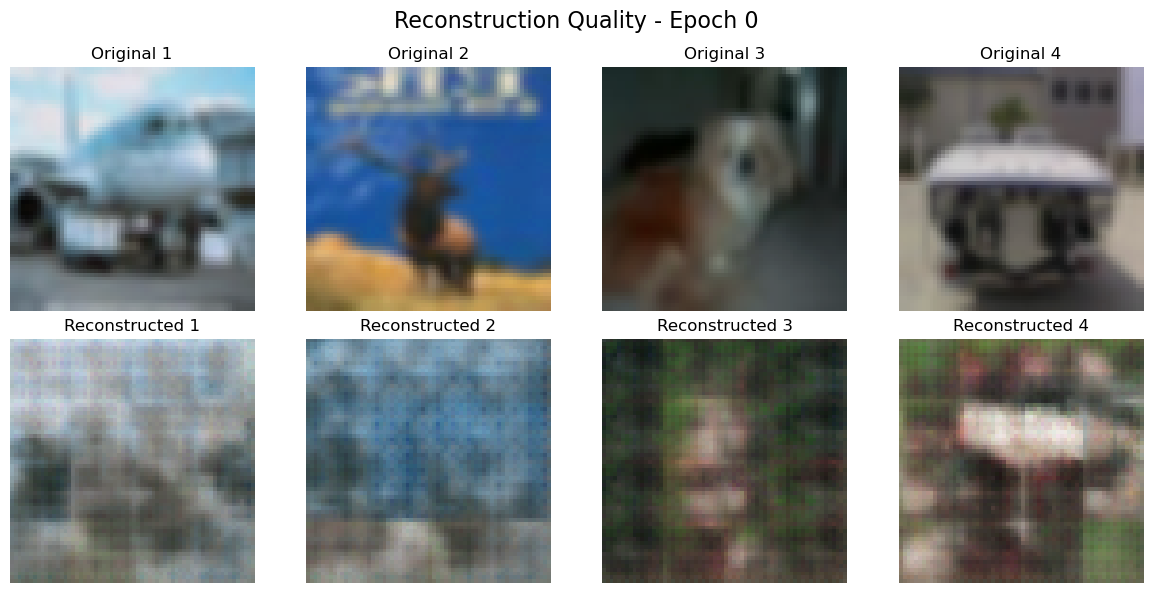

2025-08-12 11:34:11,956 - __main__.HybridTrainer - INFO - Epoch 1 Step 0: | G_loss=0.2854 | Crit_loss=-0.0119 | W_dist=0.0119
2025-08-12 11:34:35,316 - __main__.HybridTrainer - INFO - Epoch 1 Step 100: | G_loss=0.2939 | Crit_loss=-0.0052 | W_dist=0.0052
2025-08-12 11:34:59,086 - __main__.HybridTrainer - INFO - Epoch 1 Step 200: | G_loss=0.3211 | Crit_loss=0.0041 | W_dist=-0.0041
2025-08-12 11:35:22,443 - __main__.HybridTrainer - INFO - Epoch 1 Step 300: | G_loss=0.3239 | Crit_loss=0.0002 | W_dist=-0.0002
2025-08-12 11:35:43,659 - __main__.HybridTrainer - INFO - ================================================================================
2025-08-12 11:35:43,661 - __main__.HybridTrainer - INFO - EPOCH 1 COMPLETED in 92.0s
2025-08-12 11:35:43,662 - __main__.HybridTrainer - INFO - Generator_total_loss: 0.3205
2025-08-12 11:35:43,663 - __main__.HybridTrainer - INFO - Critic_loss: -0.0070
2025-08-12 11:35:43,664 - __main__.HybridTrainer - INFO - Wasserstein_distance: 0.0070
2025-08-12 11

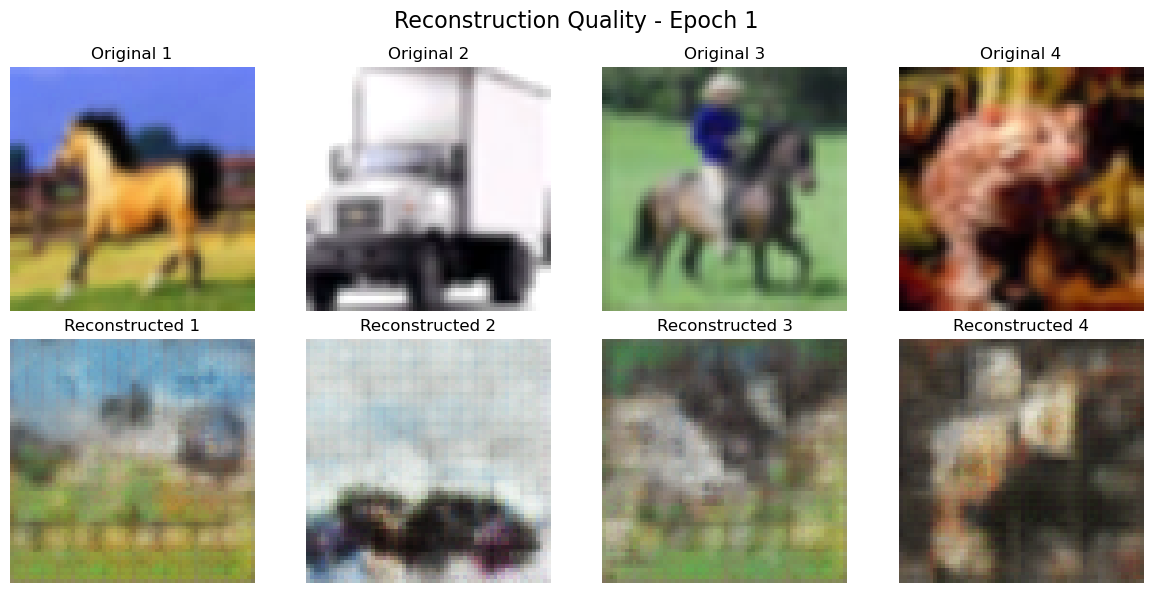

2025-08-12 11:35:44,826 - __main__.HybridTrainer - INFO - Epoch 2 Step 0: | G_loss=0.2914 | Crit_loss=-0.0016 | W_dist=0.0016
2025-08-12 11:36:08,183 - __main__.HybridTrainer - INFO - Epoch 2 Step 100: | G_loss=0.2852 | Crit_loss=-0.0071 | W_dist=0.0071
2025-08-12 11:36:31,983 - __main__.HybridTrainer - INFO - Epoch 2 Step 200: | G_loss=0.3459 | Crit_loss=-0.0020 | W_dist=0.0020
2025-08-12 11:36:55,435 - __main__.HybridTrainer - INFO - Epoch 2 Step 300: | G_loss=0.2624 | Crit_loss=-0.0030 | W_dist=0.0030
2025-08-12 11:37:16,605 - __main__.HybridTrainer - INFO - ================================================================================
2025-08-12 11:37:16,606 - __main__.HybridTrainer - INFO - EPOCH 2 COMPLETED in 92.0s
2025-08-12 11:37:16,607 - __main__.HybridTrainer - INFO - Generator_total_loss: 0.2948
2025-08-12 11:37:16,608 - __main__.HybridTrainer - INFO - Critic_loss: -0.0034
2025-08-12 11:37:16,609 - __main__.HybridTrainer - INFO - Wasserstein_distance: 0.0034
2025-08-12 11

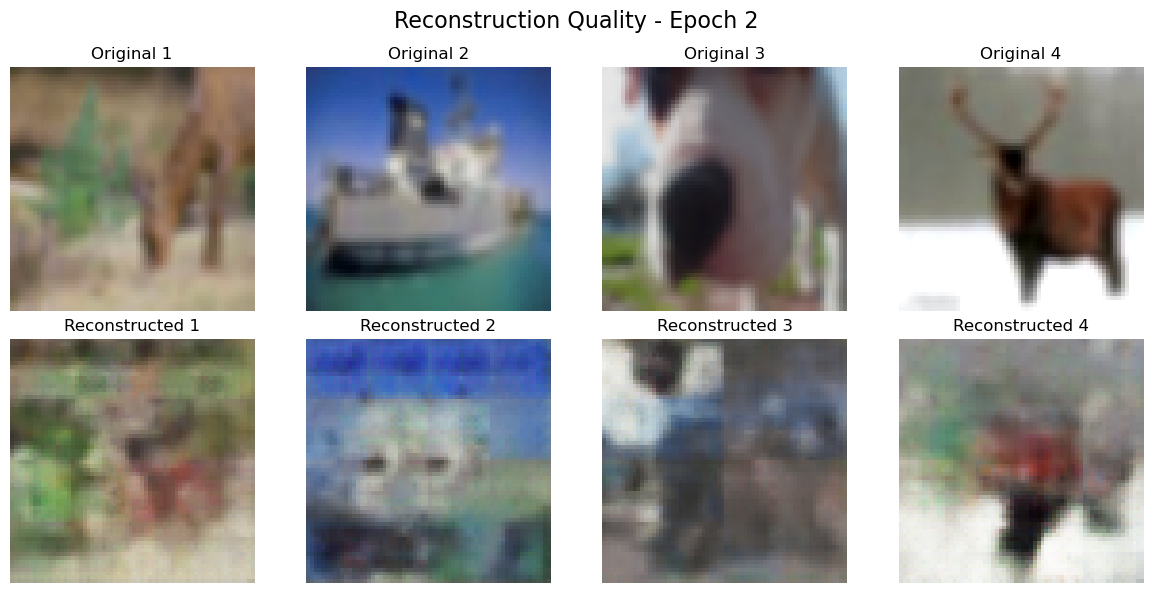

2025-08-12 11:37:17,782 - __main__.HybridTrainer - INFO - Epoch 3 Step 0: | G_loss=0.2647 | Crit_loss=-0.0083 | W_dist=0.0083
2025-08-12 11:37:41,427 - __main__.HybridTrainer - INFO - Epoch 3 Step 100: | G_loss=0.2793 | Crit_loss=-0.0032 | W_dist=0.0032
2025-08-12 11:38:05,411 - __main__.HybridTrainer - INFO - Epoch 3 Step 200: | G_loss=0.2946 | Crit_loss=-0.0069 | W_dist=0.0069
2025-08-12 11:38:28,779 - __main__.HybridTrainer - INFO - Epoch 3 Step 300: | G_loss=0.2802 | Crit_loss=-0.0022 | W_dist=0.0022
2025-08-12 11:38:50,154 - __main__.HybridTrainer - INFO - ================================================================================
2025-08-12 11:38:50,157 - __main__.HybridTrainer - INFO - EPOCH 3 COMPLETED in 92.6s
2025-08-12 11:38:50,158 - __main__.HybridTrainer - INFO - Generator_total_loss: 0.2705
2025-08-12 11:38:50,159 - __main__.HybridTrainer - INFO - Critic_loss: -0.0023
2025-08-12 11:38:50,160 - __main__.HybridTrainer - INFO - Wasserstein_distance: 0.0023
2025-08-12 11

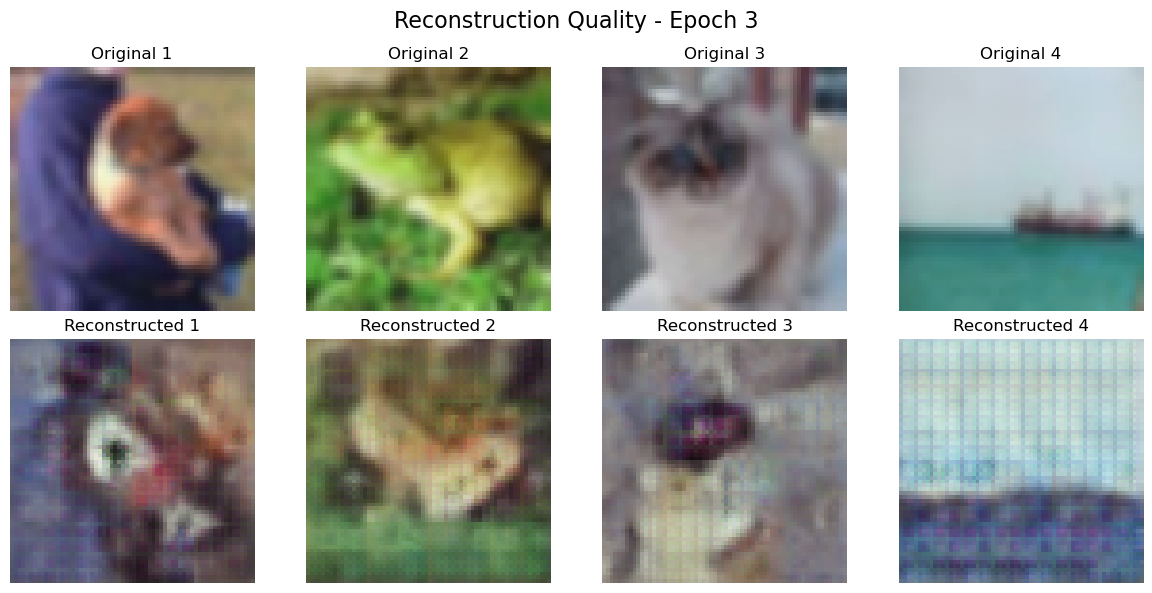

2025-08-12 11:38:51,337 - __main__.HybridTrainer - INFO - Epoch 4 Step 0: | G_loss=0.2678 | Crit_loss=0.0033 | W_dist=-0.0033
2025-08-12 11:39:14,902 - __main__.HybridTrainer - INFO - Epoch 4 Step 100: | G_loss=0.2121 | Crit_loss=-0.0007 | W_dist=0.0007
2025-08-12 11:39:38,305 - __main__.HybridTrainer - INFO - Epoch 4 Step 200: | G_loss=0.2672 | Crit_loss=-0.0030 | W_dist=0.0030
2025-08-12 11:40:02,138 - __main__.HybridTrainer - INFO - Epoch 4 Step 300: | G_loss=0.2565 | Crit_loss=-0.0021 | W_dist=0.0021
2025-08-12 11:40:23,101 - __main__.HybridTrainer - INFO - ================================================================================
2025-08-12 11:40:23,103 - __main__.HybridTrainer - INFO - EPOCH 4 COMPLETED in 92.0s
2025-08-12 11:40:23,103 - __main__.HybridTrainer - INFO - Generator_total_loss: 0.2598
2025-08-12 11:40:23,104 - __main__.HybridTrainer - INFO - Critic_loss: -0.0017
2025-08-12 11:40:23,104 - __main__.HybridTrainer - INFO - Wasserstein_distance: 0.0017
2025-08-12 11

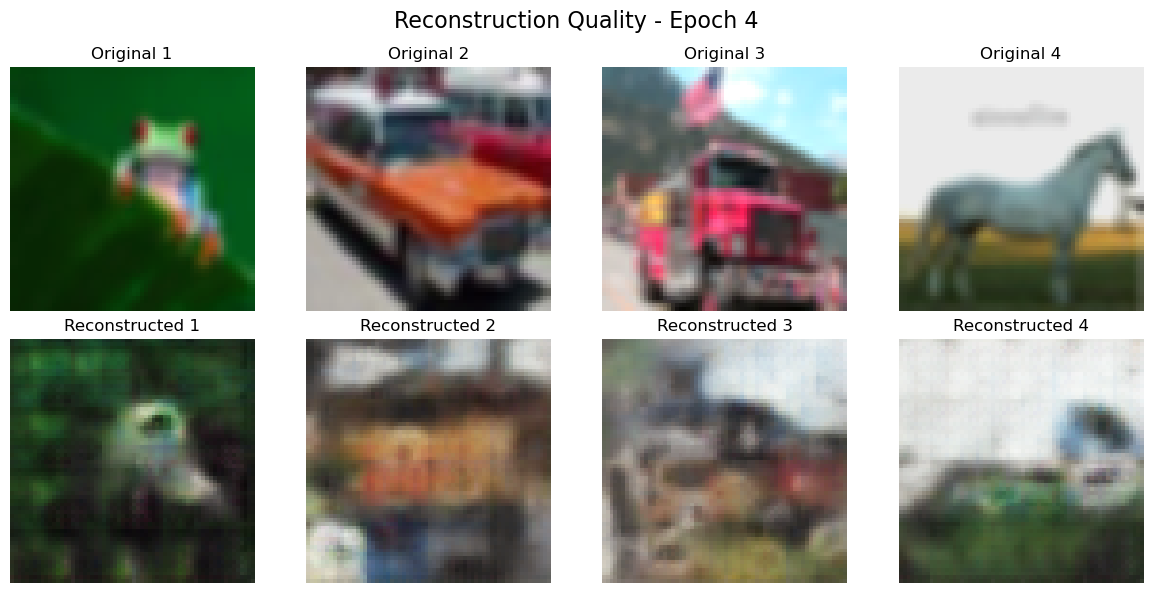

2025-08-12 11:40:24,501 - __main__.HybridTrainer - INFO - Epoch 5 Step 0: | G_loss=0.2696 | Crit_loss=0.0002 | W_dist=-0.0002
2025-08-12 11:40:48,330 - __main__.HybridTrainer - INFO - Epoch 5 Step 100: | G_loss=0.2439 | Crit_loss=-0.0034 | W_dist=0.0034
2025-08-12 11:41:11,676 - __main__.HybridTrainer - INFO - Epoch 5 Step 200: | G_loss=0.2723 | Crit_loss=-0.0016 | W_dist=0.0016
2025-08-12 11:41:35,505 - __main__.HybridTrainer - INFO - Epoch 5 Step 300: | G_loss=0.2653 | Crit_loss=-0.0031 | W_dist=0.0031
2025-08-12 11:41:56,457 - __main__.HybridTrainer - INFO - ================================================================================
2025-08-12 11:41:56,460 - __main__.HybridTrainer - INFO - EPOCH 5 COMPLETED in 92.2s
2025-08-12 11:41:56,462 - __main__.HybridTrainer - INFO - Generator_total_loss: 0.2609
2025-08-12 11:41:56,463 - __main__.HybridTrainer - INFO - Critic_loss: -0.0014
2025-08-12 11:41:56,463 - __main__.HybridTrainer - INFO - Wasserstein_distance: 0.0014
2025-08-12 11

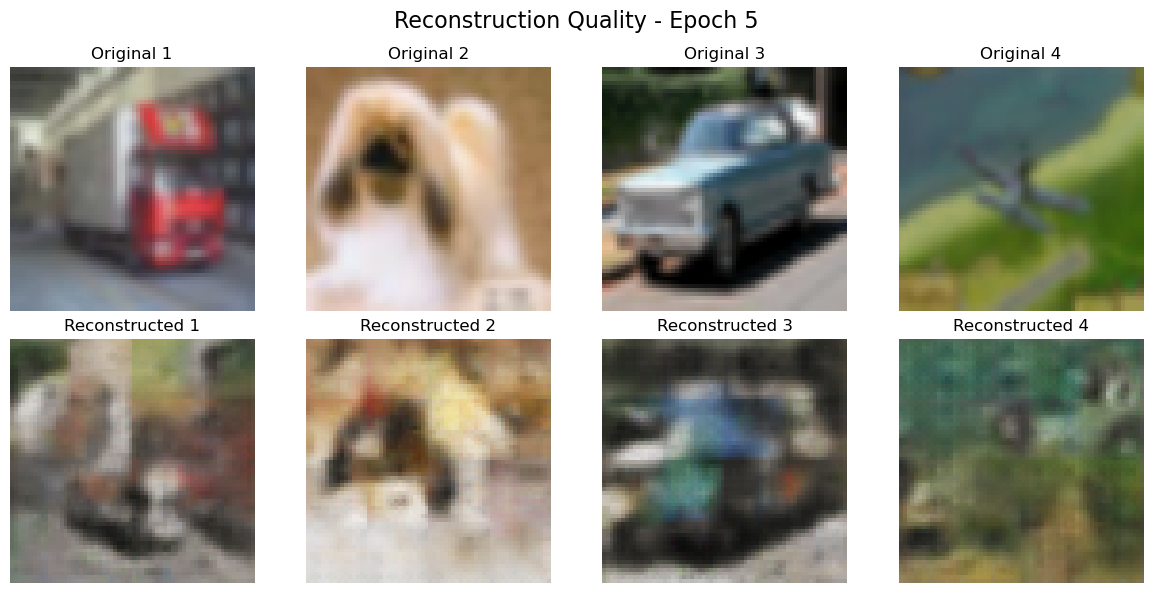

2025-08-12 11:41:57,620 - __main__.HybridTrainer - INFO - Epoch 6 Step 0: | G_loss=0.2669 | Crit_loss=-0.0041 | W_dist=0.0041
2025-08-12 11:42:21,595 - __main__.HybridTrainer - INFO - Epoch 6 Step 100: | G_loss=0.2634 | Crit_loss=-0.0018 | W_dist=0.0018
2025-08-12 11:42:45,144 - __main__.HybridTrainer - INFO - Epoch 6 Step 200: | G_loss=0.2838 | Crit_loss=-0.0014 | W_dist=0.0014
2025-08-12 11:43:09,058 - __main__.HybridTrainer - INFO - Epoch 6 Step 300: | G_loss=0.2816 | Crit_loss=-0.0021 | W_dist=0.0021
2025-08-12 11:43:29,849 - __main__.HybridTrainer - INFO - ================================================================================
2025-08-12 11:43:29,850 - __main__.HybridTrainer - INFO - EPOCH 6 COMPLETED in 92.5s
2025-08-12 11:43:29,851 - __main__.HybridTrainer - INFO - Generator_total_loss: 0.2577
2025-08-12 11:43:29,852 - __main__.HybridTrainer - INFO - Critic_loss: -0.0012
2025-08-12 11:43:29,853 - __main__.HybridTrainer - INFO - Wasserstein_distance: 0.0012
2025-08-12 11

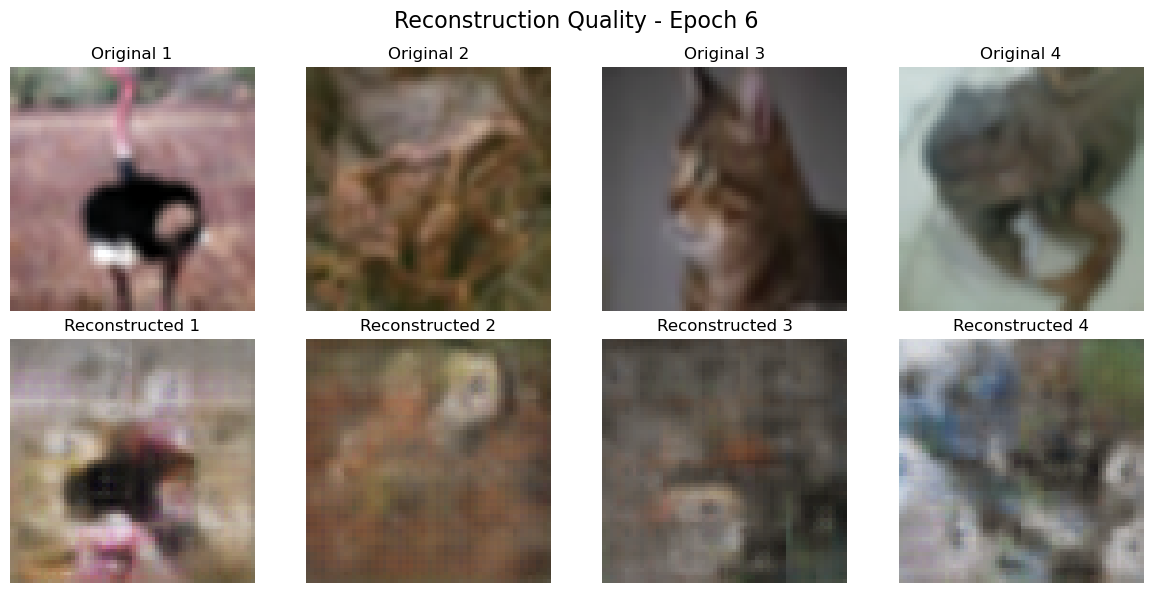

2025-08-12 11:43:30,964 - __main__.HybridTrainer - INFO - Epoch 7 Step 0: | G_loss=0.2366 | Crit_loss=-0.0018 | W_dist=0.0018
2025-08-12 11:43:54,698 - __main__.HybridTrainer - INFO - Epoch 7 Step 100: | G_loss=0.2507 | Crit_loss=-0.0012 | W_dist=0.0012
2025-08-12 11:44:18,363 - __main__.HybridTrainer - INFO - Epoch 7 Step 200: | G_loss=0.2265 | Crit_loss=-0.0047 | W_dist=0.0047
2025-08-12 11:44:41,750 - __main__.HybridTrainer - INFO - Epoch 7 Step 300: | G_loss=0.2740 | Crit_loss=-0.0006 | W_dist=0.0006
2025-08-12 11:45:03,073 - __main__.HybridTrainer - INFO - ================================================================================
2025-08-12 11:45:03,073 - __main__.HybridTrainer - INFO - EPOCH 7 COMPLETED in 92.3s
2025-08-12 11:45:03,074 - __main__.HybridTrainer - INFO - Generator_total_loss: 0.2529
2025-08-12 11:45:03,074 - __main__.HybridTrainer - INFO - Critic_loss: -0.0010
2025-08-12 11:45:03,075 - __main__.HybridTrainer - INFO - Wasserstein_distance: 0.0010
2025-08-12 11

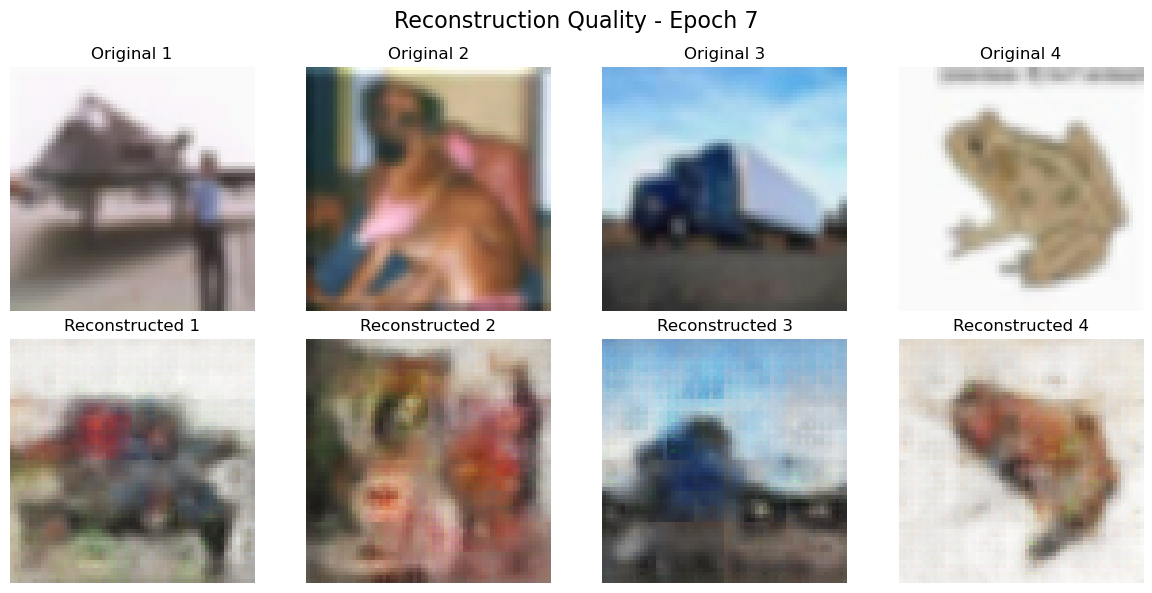

2025-08-12 11:45:04,180 - __main__.HybridTrainer - INFO - Epoch 8 Step 0: | G_loss=0.2552 | Crit_loss=-0.0024 | W_dist=0.0024
2025-08-12 11:45:27,618 - __main__.HybridTrainer - INFO - Epoch 8 Step 100: | G_loss=0.2555 | Crit_loss=-0.0016 | W_dist=0.0016
2025-08-12 11:45:51,463 - __main__.HybridTrainer - INFO - Epoch 8 Step 200: | G_loss=0.2892 | Crit_loss=-0.0026 | W_dist=0.0026
2025-08-12 11:46:15,084 - __main__.HybridTrainer - INFO - Epoch 8 Step 300: | G_loss=0.2431 | Crit_loss=-0.0027 | W_dist=0.0027
2025-08-12 11:46:36,244 - __main__.HybridTrainer - INFO - ================================================================================
2025-08-12 11:46:36,246 - __main__.HybridTrainer - INFO - EPOCH 8 COMPLETED in 92.3s
2025-08-12 11:46:36,247 - __main__.HybridTrainer - INFO - Generator_total_loss: 0.2459
2025-08-12 11:46:36,248 - __main__.HybridTrainer - INFO - Critic_loss: -0.0009
2025-08-12 11:46:36,249 - __main__.HybridTrainer - INFO - Wasserstein_distance: 0.0009
2025-08-12 11

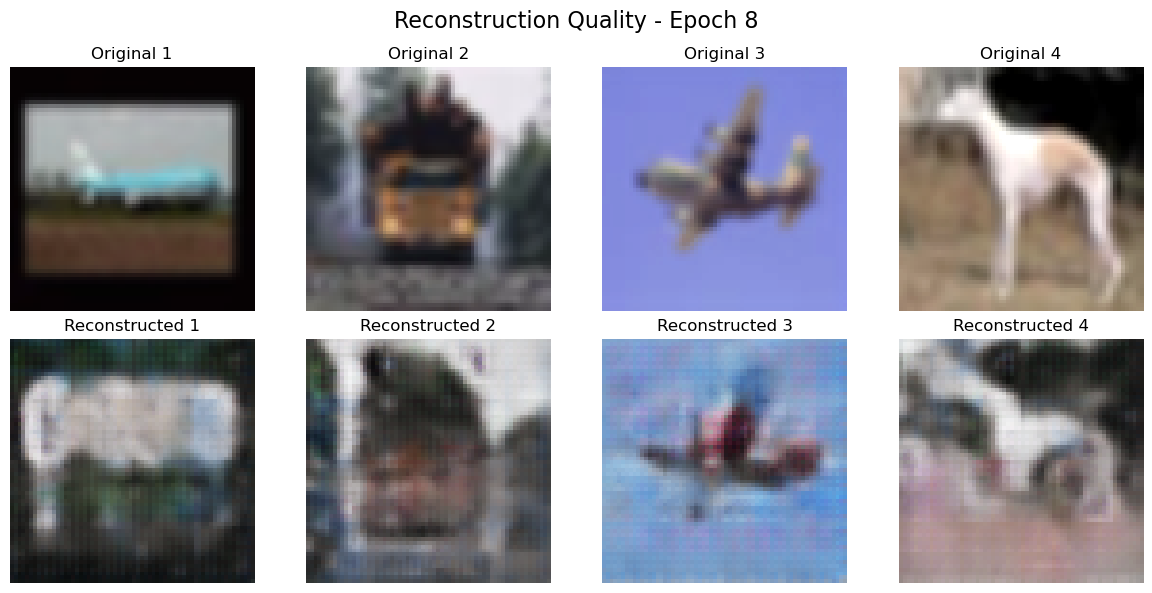

2025-08-12 11:46:37,417 - __main__.HybridTrainer - INFO - Epoch 9 Step 0: | G_loss=0.2306 | Crit_loss=0.0057 | W_dist=-0.0057
2025-08-12 11:47:00,704 - __main__.HybridTrainer - INFO - Epoch 9 Step 100: | G_loss=0.2397 | Crit_loss=0.0021 | W_dist=-0.0021
2025-08-12 11:47:24,590 - __main__.HybridTrainer - INFO - Epoch 9 Step 200: | G_loss=0.2238 | Crit_loss=0.0032 | W_dist=-0.0032
2025-08-12 11:47:47,892 - __main__.HybridTrainer - INFO - Epoch 9 Step 300: | G_loss=0.2484 | Crit_loss=-0.0000 | W_dist=0.0000
2025-08-12 11:48:09,150 - __main__.HybridTrainer - INFO - ================================================================================
2025-08-12 11:48:09,151 - __main__.HybridTrainer - INFO - EPOCH 9 COMPLETED in 92.0s
2025-08-12 11:48:09,152 - __main__.HybridTrainer - INFO - Generator_total_loss: 0.2393
2025-08-12 11:48:09,153 - __main__.HybridTrainer - INFO - Critic_loss: -0.0008
2025-08-12 11:48:09,154 - __main__.HybridTrainer - INFO - Wasserstein_distance: 0.0008
2025-08-12 11

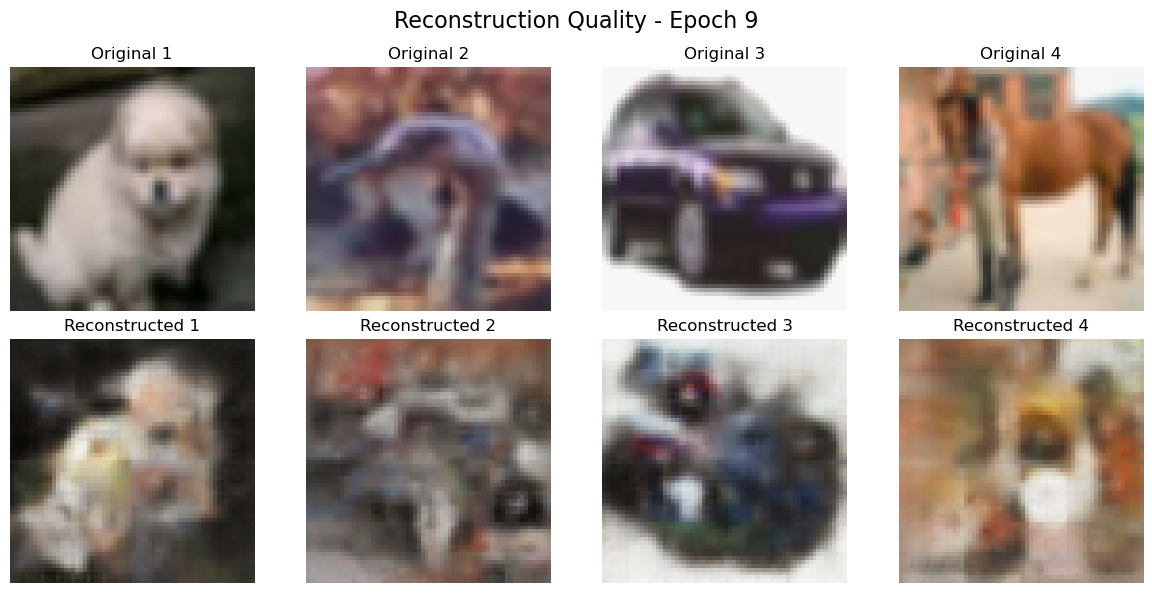

2025-08-12 11:48:10,322 - __main__.HybridTrainer - INFO - Epoch 10 Step 0: | G_loss=0.2474 | Crit_loss=-0.0011 | W_dist=0.0011
2025-08-12 11:48:33,968 - __main__.HybridTrainer - INFO - Epoch 10 Step 100: | G_loss=0.2140 | Crit_loss=-0.0026 | W_dist=0.0026
2025-08-12 11:48:57,642 - __main__.HybridTrainer - INFO - Epoch 10 Step 200: | G_loss=0.2409 | Crit_loss=-0.0001 | W_dist=0.0001
2025-08-12 11:49:21,210 - __main__.HybridTrainer - INFO - Epoch 10 Step 300: | G_loss=0.2396 | Crit_loss=-0.0014 | W_dist=0.0014
2025-08-12 11:49:42,233 - __main__.HybridTrainer - INFO - ================================================================================
2025-08-12 11:49:42,234 - __main__.HybridTrainer - INFO - EPOCH 10 COMPLETED in 92.2s
2025-08-12 11:49:42,236 - __main__.HybridTrainer - INFO - Generator_total_loss: 0.2344
2025-08-12 11:49:42,237 - __main__.HybridTrainer - INFO - Critic_loss: -0.0007
2025-08-12 11:49:42,238 - __main__.HybridTrainer - INFO - Wasserstein_distance: 0.0007
2025-08-

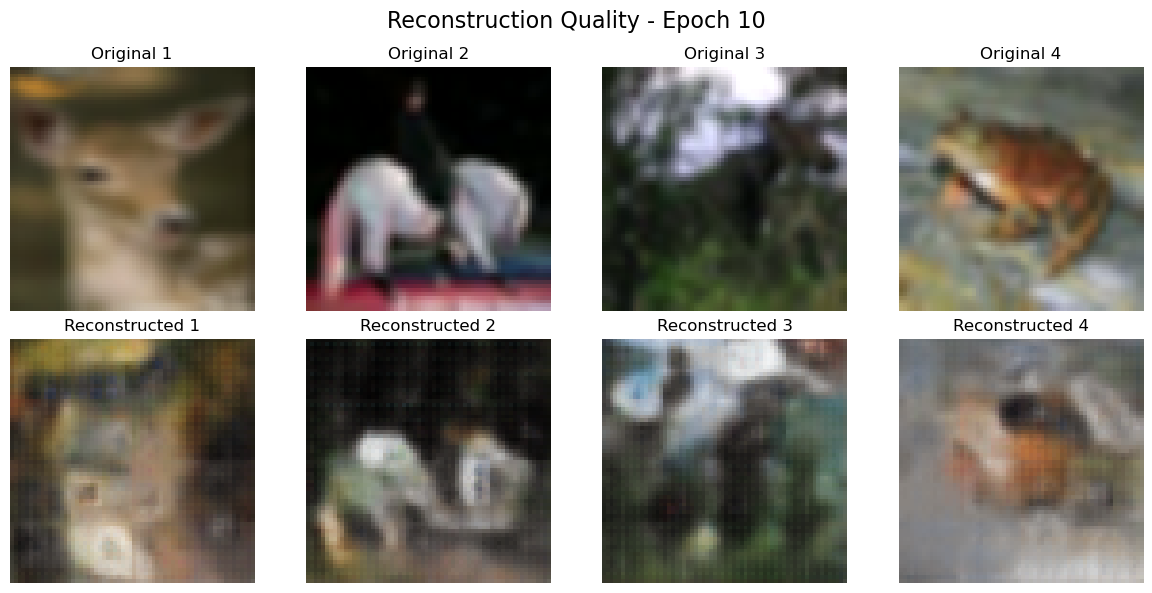

2025-08-12 11:49:43,641 - __main__.HybridTrainer - INFO - Epoch 11 Step 0: | G_loss=0.2406 | Crit_loss=0.0023 | W_dist=-0.0023
2025-08-12 11:50:07,572 - __main__.HybridTrainer - INFO - Epoch 11 Step 100: | G_loss=0.2249 | Crit_loss=-0.0020 | W_dist=0.0020
2025-08-12 11:50:31,050 - __main__.HybridTrainer - INFO - Epoch 11 Step 200: | G_loss=0.2437 | Crit_loss=-0.0013 | W_dist=0.0013
2025-08-12 11:50:54,935 - __main__.HybridTrainer - INFO - Epoch 11 Step 300: | G_loss=0.2301 | Crit_loss=-0.0007 | W_dist=0.0007
2025-08-12 11:51:15,949 - __main__.HybridTrainer - INFO - ================================================================================
2025-08-12 11:51:15,950 - __main__.HybridTrainer - INFO - EPOCH 11 COMPLETED in 92.6s
2025-08-12 11:51:15,951 - __main__.HybridTrainer - INFO - Generator_total_loss: 0.2316
2025-08-12 11:51:15,952 - __main__.HybridTrainer - INFO - Critic_loss: -0.0006
2025-08-12 11:51:15,953 - __main__.HybridTrainer - INFO - Wasserstein_distance: 0.0006
2025-08-

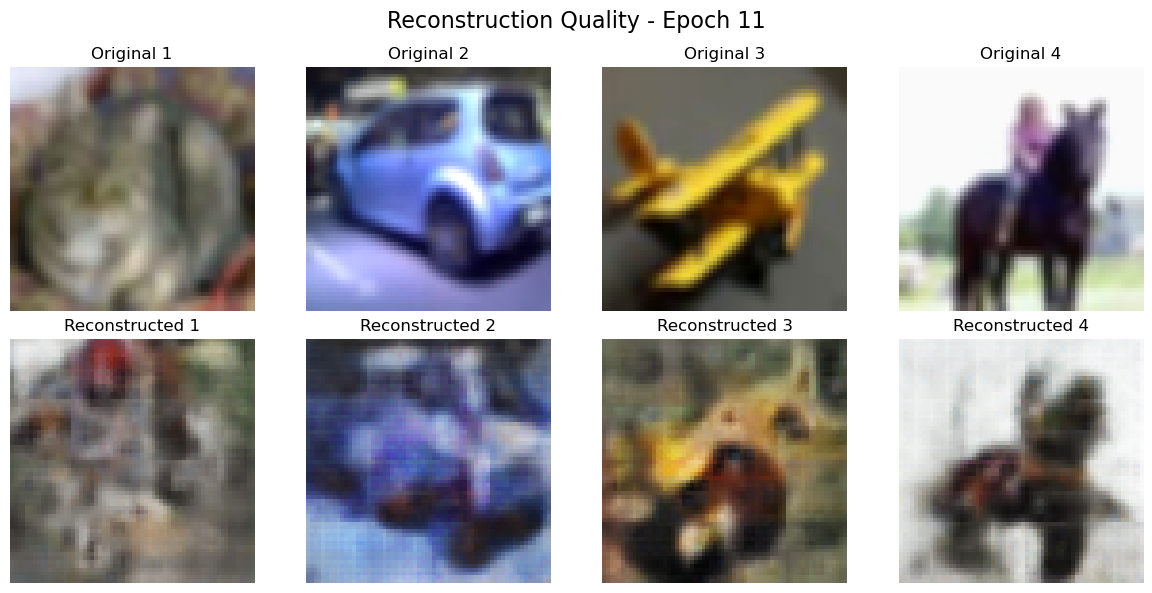

2025-08-12 11:51:17,081 - __main__.HybridTrainer - INFO - Epoch 12 Step 0: | G_loss=0.2505 | Crit_loss=0.0022 | W_dist=-0.0022
2025-08-12 11:51:40,968 - __main__.HybridTrainer - INFO - Epoch 12 Step 100: | G_loss=0.2466 | Crit_loss=-0.0021 | W_dist=0.0021
2025-08-12 11:52:04,628 - __main__.HybridTrainer - INFO - Epoch 12 Step 200: | G_loss=0.2756 | Crit_loss=-0.0005 | W_dist=0.0005
2025-08-12 11:52:28,457 - __main__.HybridTrainer - INFO - Epoch 12 Step 300: | G_loss=0.2060 | Crit_loss=0.0027 | W_dist=-0.0027
2025-08-12 11:52:49,245 - __main__.HybridTrainer - INFO - ================================================================================
2025-08-12 11:52:49,246 - __main__.HybridTrainer - INFO - EPOCH 12 COMPLETED in 92.4s
2025-08-12 11:52:49,247 - __main__.HybridTrainer - INFO - Generator_total_loss: 0.2296
2025-08-12 11:52:49,248 - __main__.HybridTrainer - INFO - Critic_loss: -0.0006
2025-08-12 11:52:49,248 - __main__.HybridTrainer - INFO - Wasserstein_distance: 0.0006
2025-08-

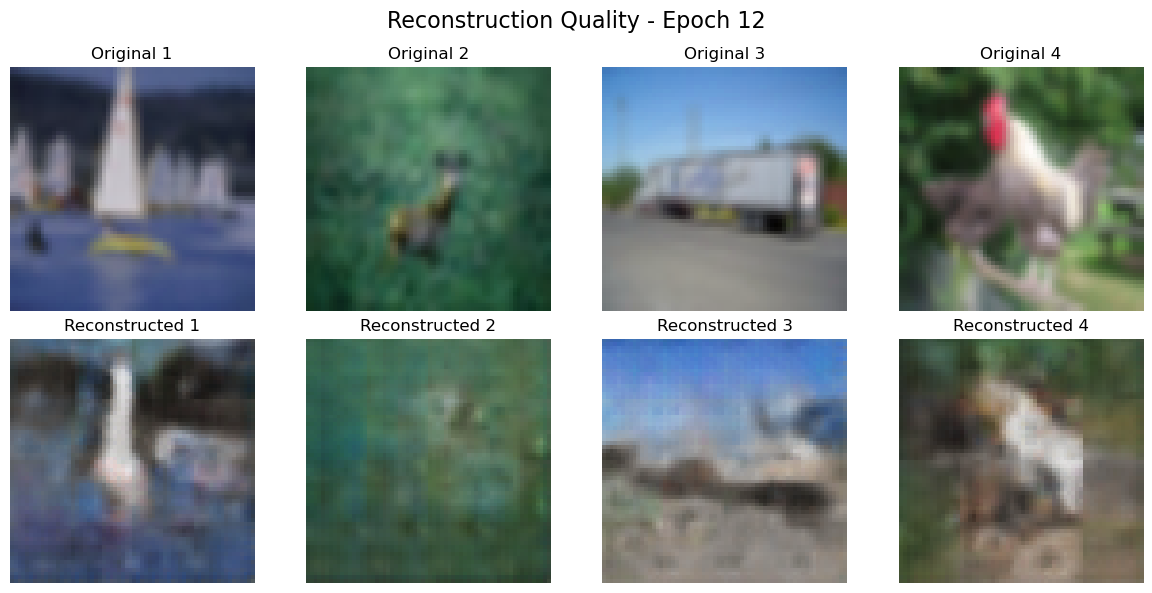

2025-08-12 11:52:50,422 - __main__.HybridTrainer - INFO - Epoch 13 Step 0: | G_loss=0.2180 | Crit_loss=0.0001 | W_dist=-0.0001
2025-08-12 11:53:14,446 - __main__.HybridTrainer - INFO - Epoch 13 Step 100: | G_loss=0.2111 | Crit_loss=0.0003 | W_dist=-0.0003
2025-08-12 11:53:37,880 - __main__.HybridTrainer - INFO - Epoch 13 Step 200: | G_loss=0.2353 | Crit_loss=-0.0005 | W_dist=0.0005
2025-08-12 11:54:01,595 - __main__.HybridTrainer - INFO - Epoch 13 Step 300: | G_loss=0.2279 | Crit_loss=-0.0005 | W_dist=0.0005
2025-08-12 11:54:22,745 - __main__.HybridTrainer - INFO - ================================================================================
2025-08-12 11:54:22,746 - __main__.HybridTrainer - INFO - EPOCH 13 COMPLETED in 92.6s
2025-08-12 11:54:22,747 - __main__.HybridTrainer - INFO - Generator_total_loss: 0.2317
2025-08-12 11:54:22,747 - __main__.HybridTrainer - INFO - Critic_loss: -0.0006
2025-08-12 11:54:22,748 - __main__.HybridTrainer - INFO - Wasserstein_distance: 0.0006
2025-08-

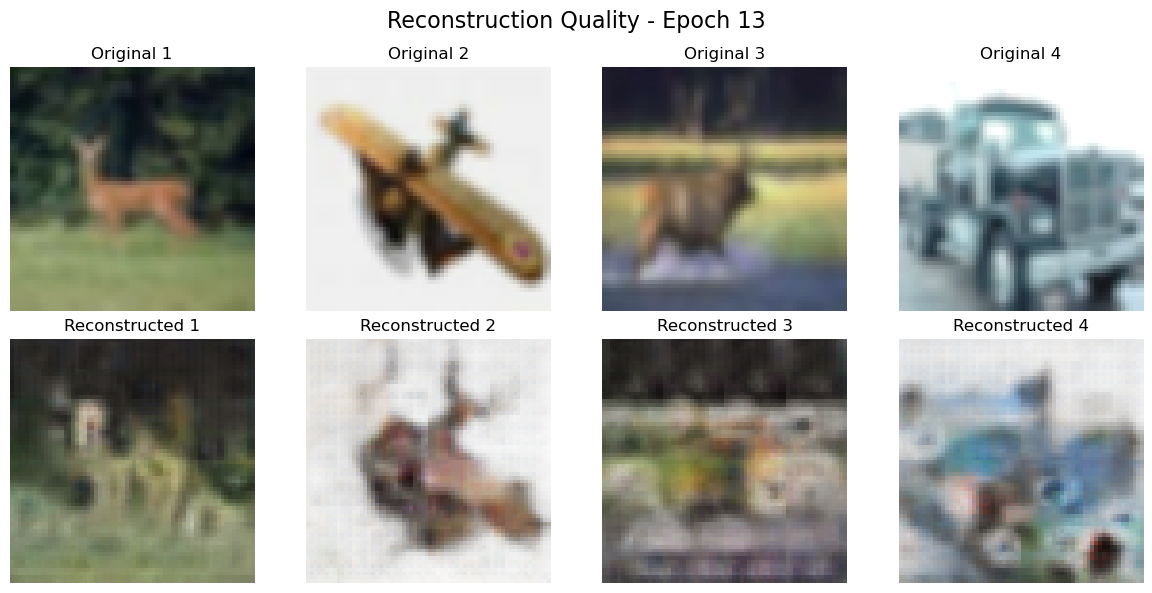

2025-08-12 11:54:23,869 - __main__.HybridTrainer - INFO - Epoch 14 Step 0: | G_loss=0.2078 | Crit_loss=0.0013 | W_dist=-0.0013
2025-08-12 11:54:47,465 - __main__.HybridTrainer - INFO - Epoch 14 Step 100: | G_loss=0.2201 | Crit_loss=-0.0003 | W_dist=0.0003
2025-08-12 11:55:11,277 - __main__.HybridTrainer - INFO - Epoch 14 Step 200: | G_loss=0.2302 | Crit_loss=-0.0003 | W_dist=0.0003
2025-08-12 11:55:34,792 - __main__.HybridTrainer - INFO - Epoch 14 Step 300: | G_loss=0.2306 | Crit_loss=-0.0026 | W_dist=0.0026
2025-08-12 11:55:56,005 - __main__.HybridTrainer - INFO - ================================================================================
2025-08-12 11:55:56,007 - __main__.HybridTrainer - INFO - EPOCH 14 COMPLETED in 92.3s
2025-08-12 11:55:56,008 - __main__.HybridTrainer - INFO - Generator_total_loss: 0.2284
2025-08-12 11:55:56,009 - __main__.HybridTrainer - INFO - Critic_loss: -0.0005
2025-08-12 11:55:56,010 - __main__.HybridTrainer - INFO - Wasserstein_distance: 0.0005
2025-08-

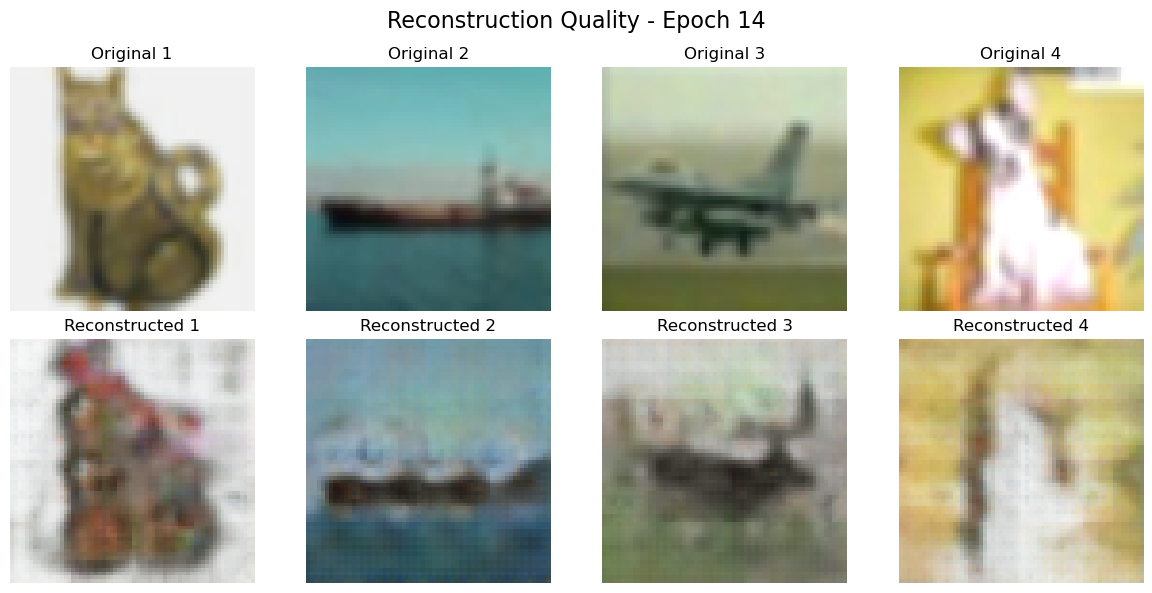

2025-08-12 11:55:57,183 - __main__.HybridTrainer - INFO - Epoch 15 Step 0: | G_loss=0.2301 | Crit_loss=0.0044 | W_dist=-0.0044
2025-08-12 11:56:20,564 - __main__.HybridTrainer - INFO - Epoch 15 Step 100: | G_loss=0.2153 | Crit_loss=-0.0010 | W_dist=0.0010
2025-08-12 11:56:44,427 - __main__.HybridTrainer - INFO - Epoch 15 Step 200: | G_loss=0.2267 | Crit_loss=-0.0011 | W_dist=0.0011
2025-08-12 11:57:08,036 - __main__.HybridTrainer - INFO - Epoch 15 Step 300: | G_loss=0.2458 | Crit_loss=-0.0015 | W_dist=0.0015
2025-08-12 11:57:29,309 - __main__.HybridTrainer - INFO - ================================================================================
2025-08-12 11:57:29,310 - __main__.HybridTrainer - INFO - EPOCH 15 COMPLETED in 92.4s
2025-08-12 11:57:29,311 - __main__.HybridTrainer - INFO - Generator_total_loss: 0.2272
2025-08-12 11:57:29,312 - __main__.HybridTrainer - INFO - Critic_loss: -0.0005
2025-08-12 11:57:29,312 - __main__.HybridTrainer - INFO - Wasserstein_distance: 0.0005
2025-08-

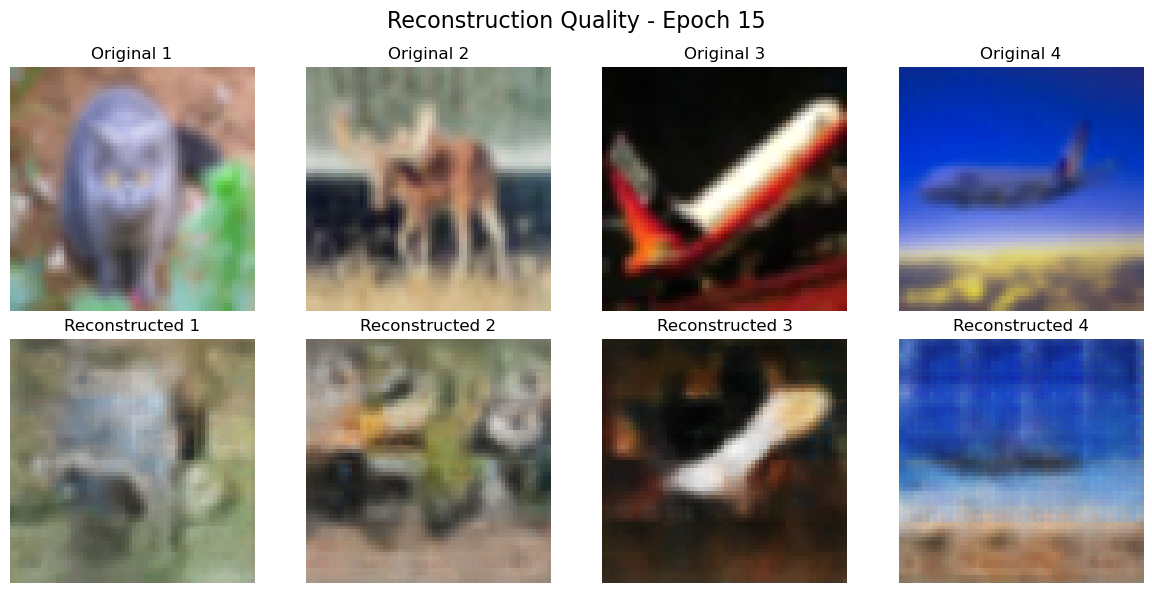

2025-08-12 11:57:30,425 - __main__.HybridTrainer - INFO - Epoch 16 Step 0: | G_loss=0.2403 | Crit_loss=-0.0011 | W_dist=0.0011
2025-08-12 11:57:53,840 - __main__.HybridTrainer - INFO - Epoch 16 Step 100: | G_loss=0.2170 | Crit_loss=-0.0014 | W_dist=0.0014
2025-08-12 11:58:17,665 - __main__.HybridTrainer - INFO - Epoch 16 Step 200: | G_loss=0.2310 | Crit_loss=-0.0016 | W_dist=0.0016
2025-08-12 11:58:41,080 - __main__.HybridTrainer - INFO - Epoch 16 Step 300: | G_loss=0.2288 | Crit_loss=0.0005 | W_dist=-0.0005
2025-08-12 11:59:02,229 - __main__.HybridTrainer - INFO - ================================================================================
2025-08-12 11:59:02,230 - __main__.HybridTrainer - INFO - EPOCH 16 COMPLETED in 92.0s
2025-08-12 11:59:02,231 - __main__.HybridTrainer - INFO - Generator_total_loss: 0.2193
2025-08-12 11:59:02,231 - __main__.HybridTrainer - INFO - Critic_loss: -0.0004
2025-08-12 11:59:02,232 - __main__.HybridTrainer - INFO - Wasserstein_distance: 0.0004
2025-08-

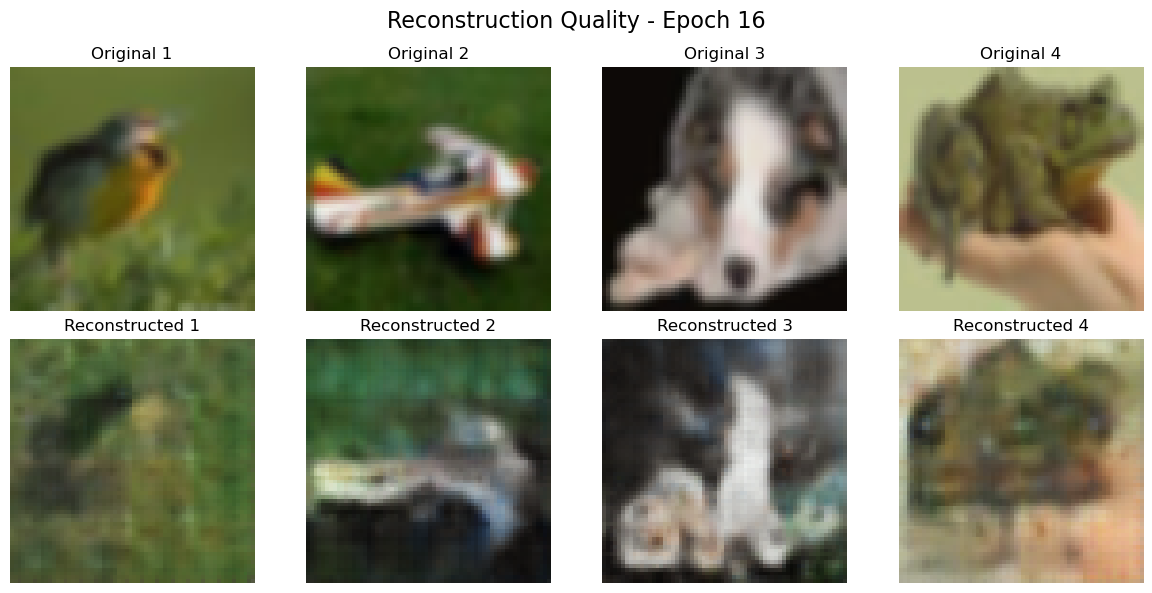

2025-08-12 11:59:03,337 - __main__.HybridTrainer - INFO - Epoch 17 Step 0: | G_loss=0.2012 | Crit_loss=-0.0011 | W_dist=0.0011
2025-08-12 11:59:27,227 - __main__.HybridTrainer - INFO - Epoch 17 Step 100: | G_loss=0.2406 | Crit_loss=-0.0003 | W_dist=0.0003
2025-08-12 11:59:50,708 - __main__.HybridTrainer - INFO - Epoch 17 Step 200: | G_loss=0.2318 | Crit_loss=0.0002 | W_dist=-0.0002
2025-08-12 12:00:14,744 - __main__.HybridTrainer - INFO - Epoch 17 Step 300: | G_loss=0.2154 | Crit_loss=0.0002 | W_dist=-0.0002
2025-08-12 12:00:35,509 - __main__.HybridTrainer - INFO - ================================================================================
2025-08-12 12:00:35,511 - __main__.HybridTrainer - INFO - EPOCH 17 COMPLETED in 92.4s
2025-08-12 12:00:35,512 - __main__.HybridTrainer - INFO - Generator_total_loss: 0.2194
2025-08-12 12:00:35,513 - __main__.HybridTrainer - INFO - Critic_loss: -0.0005
2025-08-12 12:00:35,514 - __main__.HybridTrainer - INFO - Wasserstein_distance: 0.0005
2025-08-

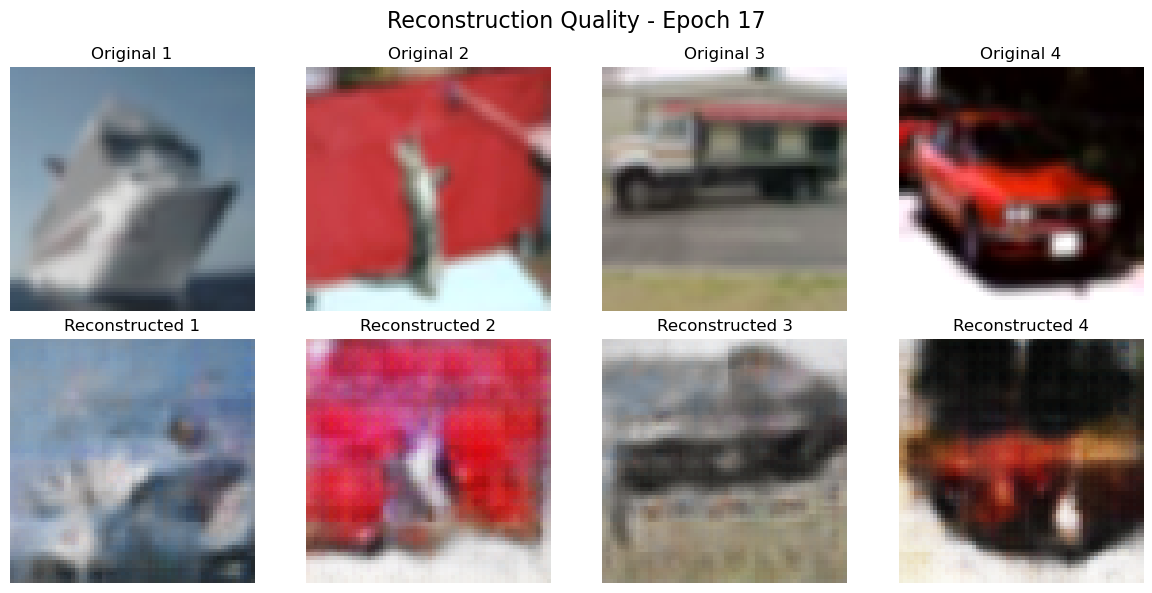

2025-08-12 12:00:36,901 - __main__.HybridTrainer - INFO - Epoch 18 Step 0: | G_loss=0.2501 | Crit_loss=-0.0000 | W_dist=0.0000
2025-08-12 12:01:00,843 - __main__.HybridTrainer - INFO - Epoch 18 Step 100: | G_loss=0.2005 | Crit_loss=-0.0007 | W_dist=0.0007
2025-08-12 12:01:24,248 - __main__.HybridTrainer - INFO - Epoch 18 Step 200: | G_loss=0.2216 | Crit_loss=-0.0010 | W_dist=0.0010
2025-08-12 12:01:48,054 - __main__.HybridTrainer - INFO - Epoch 18 Step 300: | G_loss=0.2344 | Crit_loss=-0.0019 | W_dist=0.0019
2025-08-12 12:02:09,045 - __main__.HybridTrainer - INFO - ================================================================================
2025-08-12 12:02:09,046 - __main__.HybridTrainer - INFO - EPOCH 18 COMPLETED in 92.4s
2025-08-12 12:02:09,047 - __main__.HybridTrainer - INFO - Generator_total_loss: 0.2227
2025-08-12 12:02:09,048 - __main__.HybridTrainer - INFO - Critic_loss: -0.0004
2025-08-12 12:02:09,049 - __main__.HybridTrainer - INFO - Wasserstein_distance: 0.0004
2025-08-

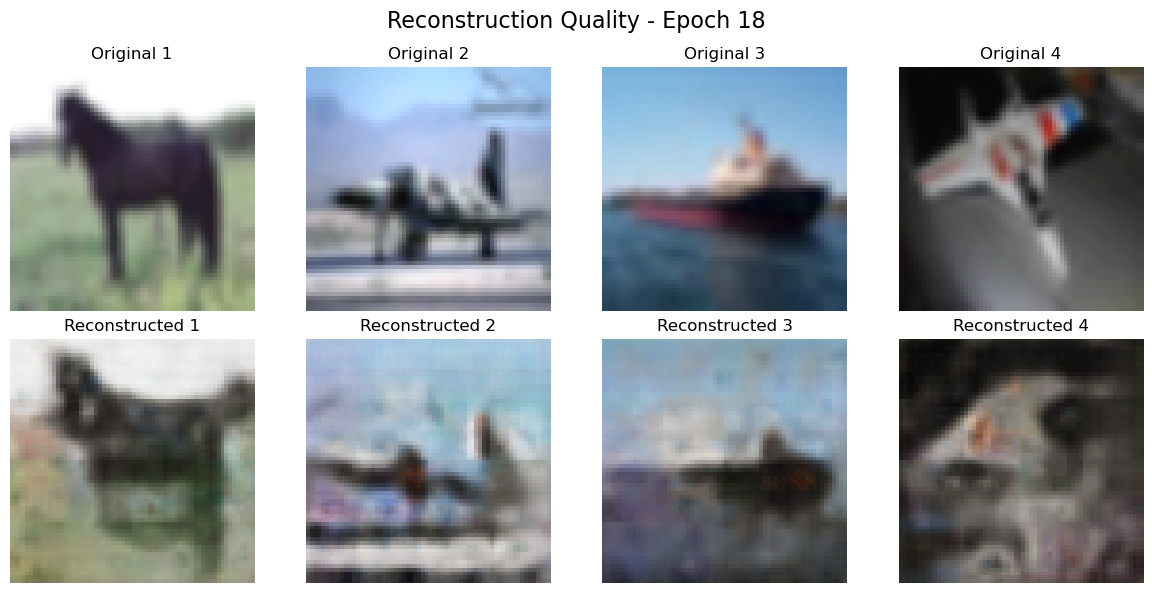

2025-08-12 12:02:10,220 - __main__.HybridTrainer - INFO - Epoch 19 Step 0: | G_loss=0.2422 | Crit_loss=0.0009 | W_dist=-0.0009
2025-08-12 12:02:34,088 - __main__.HybridTrainer - INFO - Epoch 19 Step 100: | G_loss=0.2050 | Crit_loss=0.0000 | W_dist=-0.0000
2025-08-12 12:02:57,573 - __main__.HybridTrainer - INFO - Epoch 19 Step 200: | G_loss=0.2360 | Crit_loss=-0.0013 | W_dist=0.0013
2025-08-12 12:03:21,336 - __main__.HybridTrainer - INFO - Epoch 19 Step 300: | G_loss=0.2178 | Crit_loss=0.0000 | W_dist=-0.0000
2025-08-12 12:03:42,271 - __main__.HybridTrainer - INFO - ================================================================================
2025-08-12 12:03:42,272 - __main__.HybridTrainer - INFO - EPOCH 19 COMPLETED in 92.3s
2025-08-12 12:03:42,273 - __main__.HybridTrainer - INFO - Generator_total_loss: 0.2209
2025-08-12 12:03:42,273 - __main__.HybridTrainer - INFO - Critic_loss: -0.0004
2025-08-12 12:03:42,274 - __main__.HybridTrainer - INFO - Wasserstein_distance: 0.0004
2025-08-

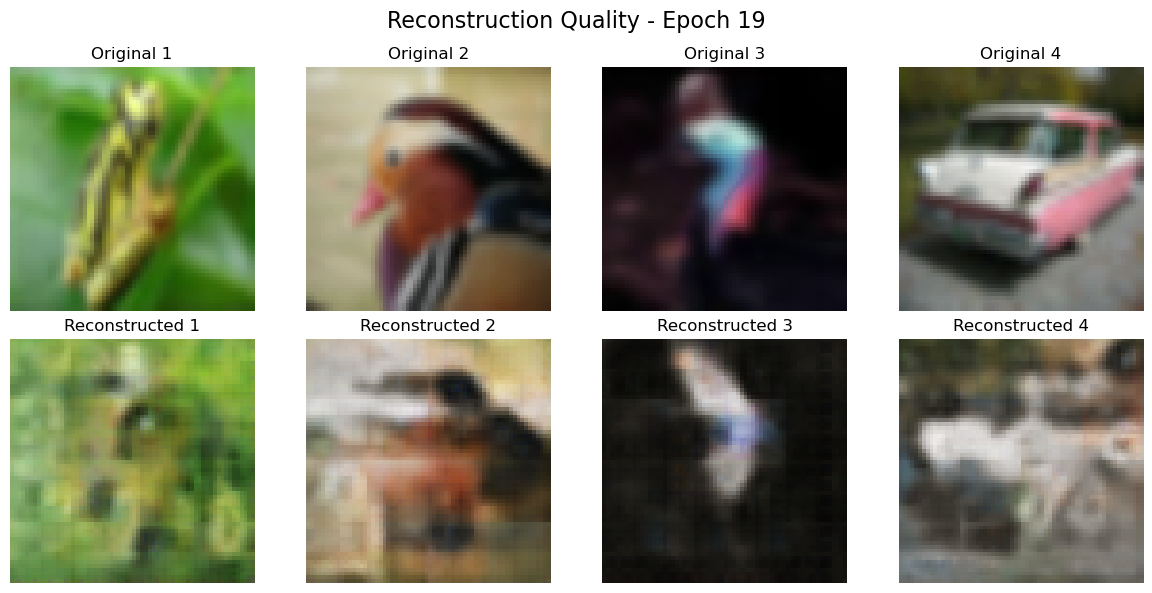

2025-08-12 12:03:43,166 - __main__.HybridTrainer - INFO - TRAINING COMPLETED in 31.1 minutes!
/tmp/ipykernel_788955/1171791984.py:304: UserWarning: Glyph 127947 (\N{WEIGHT LIFTER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sbeeredd/miniconda3/envs/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127947 (\N{WEIGHT LIFTER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


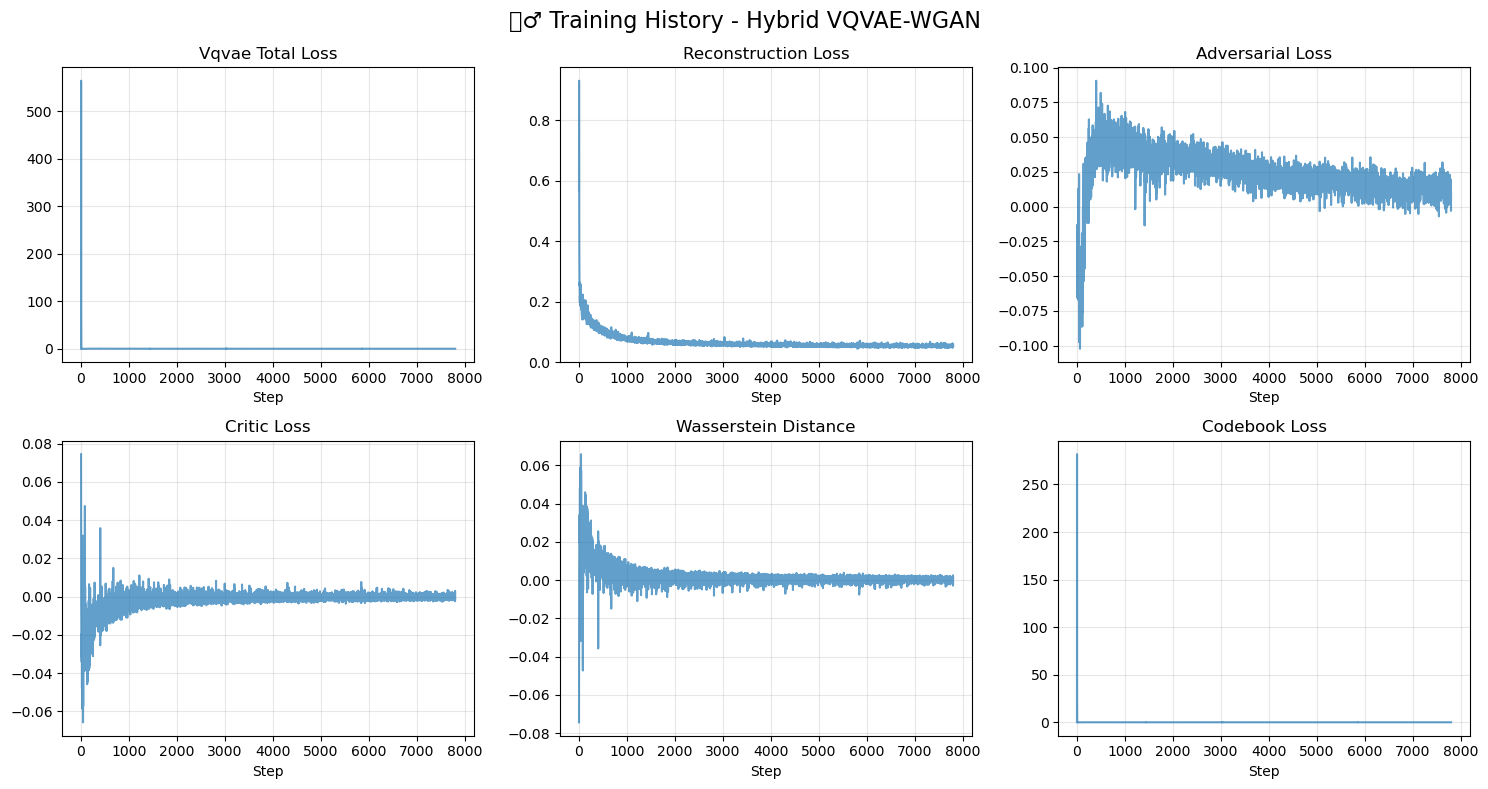

In [97]:
# Training Example with CIFAR10
logger.info("PREPARING CIFAR10 TRAINING EXAMPLE")
logger.info("="*80)

dataset_loader = DataSetLoader(batch_size=128, data_dir='./data')
dataloader, num_batches, img_size, channels = dataset_loader.load_cifar10()

USE_WEIGHT_CLIPPING = True  

model = HybridVQVAEWGAN(
    input_dim=channels,           
    latent_dim=64,               
    codebook_size=512,           
    img_size=img_size,           
    use_weight_clipping=USE_WEIGHT_CLIPPING  
)

trainer = HybridTrainer(
    model=model,
    device=device,
    vqvae_lr=1e-2,
    critic_lr=1e-3,
    lambda_gp=10,                   
    critic_iters=1,                  
    loss_weights={                   
        'reconstruction': 1,           
        'adversarial': 2,              
        'codebook': 1,                
        'commitment': 1                
    },
    use_weight_clipping=USE_WEIGHT_CLIPPING,  
    clip_value=0.01                          
)

logger.info("STARTING TRAINING...")
logger.info("="*80)

trainer.train(dataloader, num_epochs=20, log_every=100, viz_every=1)

trainer.plot_history()


In [98]:
# 🧪 TEST: Verify Weight Clipping and Gradient Penalty Implementation
logger.info("🧪 TESTING BOTH TRAINING MODES")
logger.info("="*80)

# Test 1: Create model with gradient penalty (default)
logger.info("Testing Gradient Penalty Mode...")
test_model_gp = HybridVQVAEWGAN(
    input_dim=3,
    latent_dim=64,
    codebook_size=512,
    img_size=[64, 64],
    use_weight_clipping=False  # Gradient penalty mode
)
logger.info("✅ Gradient Penalty model created successfully!")

# Test 2: Create model with weight clipping
logger.info("Testing Weight Clipping Mode...")
test_model_wc = HybridVQVAEWGAN(
    input_dim=3,
    latent_dim=64,
    codebook_size=512,
    img_size=[64, 64],
    use_weight_clipping=True   # Weight clipping mode
)
logger.info("✅ Weight Clipping model created successfully!")

# Test 3: Create trainers for both modes
logger.info("Testing Trainer Creation...")

# Gradient Penalty Trainer
test_trainer_gp = HybridTrainer(
    model=test_model_gp,
    device=device,
    vqvae_lr=1e-4,
    critic_lr=1e-4,
    lambda_gp=10,
    critic_iters=5,
    loss_weights={'reconstruction': 0.5, 'adversarial': 2.0, 'codebook': 0.25, 'commitment': 0.1},
    use_weight_clipping=False,
    clip_value=0.01
)
logger.info("✅ Gradient Penalty trainer created successfully!")

# Weight Clipping Trainer
test_trainer_wc = HybridTrainer(
    model=test_model_wc,
    device=device,
    vqvae_lr=5e-5,
    critic_lr=5e-5,
    lambda_gp=10,
    critic_iters=5,
    loss_weights={'reconstruction': 0.5, 'adversarial': 2.0, 'codebook': 0.25, 'commitment': 0.1},
    use_weight_clipping=True,
    clip_value=0.01
)
logger.info("✅ Weight Clipping trainer created successfully!")

logger.info("="*80)
logger.info("🎉 ALL TESTS PASSED! Both modes are working correctly.")
logger.info("You can now safely run either training mode.")


2025-08-12 12:03:44,008 - HybridVQVAE_WGAN - INFO - 🧪 TESTING BOTH TRAINING MODES
2025-08-12 12:03:44,010 - HybridVQVAE_WGAN - INFO - ================================================================================
2025-08-12 12:03:44,011 - HybridVQVAE_WGAN - INFO - Testing Gradient Penalty Mode...
2025-08-12 12:03:44,026 - __main__.VectorQuantizer - INFO - VectorQuantizer | codebook_size=512 | embedding_dim=64
2025-08-12 12:03:44,038 - __main__.VQVAE - INFO - DynamicVQVAE Architecture:
2025-08-12 12:03:44,039 - __main__.VQVAE - INFO -    Input: 3 channels, [64, 64]
2025-08-12 12:03:44,040 - __main__.VQVAE - INFO -    Latent: 64 dimensions
2025-08-12 12:03:44,040 - __main__.VQVAE - INFO -    Codebook: 512 entries
2025-08-12 12:03:44,041 - __main__.VQVAE - INFO -    Channel progression: 3 -> 64 -> 128 -> 256 -> 512
2025-08-12 12:03:44,042 - __main__.VQVAE - INFO -    Total params: 3,203,139
2025-08-12 12:03:44,058 - __main__.WGANCritic - INFO - DynamicWGANCritic Architecture:
2025-08-12